In [2]:
cd ..

/home/hjp/HJP/KUAICV/AbsoluteTrack


In [3]:
pwd

'/home/hjp/HJP/KUAICV/AbsoluteTrack'

In [2]:
RAW_OUTPUT = """index fingertip error : 57.81718040789004 61.59664361958636
index fingertip error : 61.97064593113247 57.19314350990683
index fingertip error : 61.58269535472488 56.744081009931904
index fingertip error : 61.2852477997528 56.14688270144223
index fingertip error : 60.94736026033752 38.54224838675356
index fingertip error : 72.11972375031512 58.80399355375261
index fingertip error : 72.71667261329786 56.855203851892135
index fingertip error : 12.169297230114992 8.547987143792483
index fingertip error : 14.259745051231409 8.4606542592323
index fingertip error : 16.425729805483307 8.721147581534193
index fingertip error : 16.087969846845617 8.728585973270308
index fingertip error : 13.488481617183455 9.385304012108472
index fingertip error : 11.45634083313944 21.051415342124095
index fingertip error : 12.086573401886113 36.247211801481356
index fingertip error : 12.09193392993826 44.031365061432325
index fingertip error : 9.50955139350309 48.238615156912715
index fingertip error : 7.0180544144989225 49.93912957612345
index fingertip error : 5.510993757219892 47.785934088176646
index fingertip error : 4.695838120707688 22.263341186131743
index fingertip error : 5.932316833583227 10.960915976831387
index fingertip error : 5.625181261523033 10.199477482779525
index fingertip error : 6.329953317810129 9.238231087426461
index fingertip error : 6.578667911085939 11.019693797737702
index fingertip error : 6.836811909961737 12.033128723700244
index fingertip error : 8.065617331972108 13.18809570672123
index fingertip error : 8.758377704248806 10.80408625076674
index fingertip error : 9.6212889518048 10.216689678520645
index fingertip error : 8.258229678581097 12.378576120401402
index fingertip error : 7.860639020593822 13.38024188031395
index fingertip error : 6.87104066123271 11.743704040557969
index fingertip error : 7.317983434543558 14.80696588869136
index fingertip error : 8.142774491525934 13.938508249083252
index fingertip error : 8.759099162599194 14.109290475294463
index fingertip error : 8.790664291819883 14.127574028629944
index fingertip error : 8.776870529228368 14.364370774556543
index fingertip error : 7.286230010933063 26.40498588544423
index fingertip error : 6.1721382007376935 38.037113625779604
index fingertip error : 5.695371151266345 39.39408377823588
index fingertip error : 6.5786102613204545 40.34676545054275
index fingertip error : 9.852003180380517 35.69386773113459
index fingertip error : 7.489097281912629 37.642627358007175
index fingertip error : 16.716110954417566 42.75763893935737
index fingertip error : 12.972711682722254 31.59520027120784
index fingertip error : 13.809135208828986 24.935879007608737
index fingertip error : 14.42773226205687 18.506119205267844
index fingertip error : 16.345369545262113 12.404118847048114
index fingertip error : 16.924749622879744 9.332100987206614
index fingertip error : 15.431001669694059 8.992606899814797
index fingertip error : 16.220421302235597 11.506839473103472
index fingertip error : 20.83199691430012 9.467615504257905
index fingertip error : 20.6449385206017 7.386851670847381
index fingertip error : 19.12996814741796 6.243127663747306
index fingertip error : 19.55582069308797 7.6912224195151015
index fingertip error : 8.00743487365611 12.121871103370765
index fingertip error : 9.398790245395372 14.82870769917784
index fingertip error : 7.543513869163458 12.897428832384314
index fingertip error : 5.269465913656292 8.612550921165232
index fingertip error : 7.900002949600646 6.0310497525726285
index fingertip error : 8.974868558628753 9.810543486493195
index fingertip error : 8.753834911406022 9.884188362149523
index fingertip error : 12.544214757676588 9.068082560779132
index fingertip error : 18.92166622247717 8.414081762351598
index fingertip error : 10.058934810610534 8.239703812539323
index fingertip error : 9.050808538368344 8.788660791978268
index fingertip error : 7.804599971978548 10.36193079989574
index fingertip error : 13.608883061054238 8.680791068402653
index fingertip error : 15.437821989511551 7.862308832982393
index fingertip error : 19.46092586462769 8.531731013278874
index fingertip error : 18.136630144146416 8.265760695012014
index fingertip error : 22.786301817909713 8.286250221655758
index fingertip error : 23.141718463456765 7.5647591562431975
index fingertip error : 23.25497226396014 7.672166186830167
index fingertip error : 24.808882426754675 6.144662318843241
index fingertip error : 22.302626476267758 6.417052141278213
index fingertip error : 22.478474923172193 5.8587777959620775
index fingertip error : 23.577478768211932 5.31209589300895
index fingertip error : 23.212650746483558 5.162152064827022
index fingertip error : 22.380713487262113 4.511119286218208
index fingertip error : 23.307049553923644 4.223733691619249
index fingertip error : 15.018946117373947 5.443652146647186
index fingertip error : 25.684594585305508 13.84260060614201
index fingertip error : 34.02177142438709 36.67123290586346
index fingertip error : 25.193363568237775 34.87154705798493
index fingertip error : 13.910345376478112 20.229572271212547
index fingertip error : 31.459066927763313 11.000125017204002
index fingertip error : 42.679877197637815 43.03509369409366
index fingertip error : 41.19821045961903 40.188336207953085
index fingertip error : 34.68373557104115 35.48676907877344
index fingertip error : 23.210721926369313 21.574966972715817
index fingertip error : 17.206276447347364 9.91377304435494
index fingertip error : 16.670958739765506 9.971659281054846
index fingertip error : 18.09598831754364 14.796832174098245
index fingertip error : 20.560644443982174 15.971977428641695
index fingertip error : 21.754488858712072 13.626167759247092
index fingertip error : 21.66494286423331 14.082695768921221
index fingertip error : 21.21676426341323 12.514198798927415
index fingertip error : 19.329479375742828 11.983501385774863
index fingertip error : 17.060316110819485 12.349294932919419
index fingertip error : 15.93775046110508 11.539751955310095
index fingertip error : 15.56457877161184 11.463636026085425
index fingertip error : 14.584388209670912 11.258184767828887
index fingertip error : 13.94375005061635 10.808528146397745
index fingertip error : 14.160593169596227 10.738822295375899
index fingertip error : 14.889704213678309 10.1674397278521
index fingertip error : 14.215666541607783 9.502990343746244
index fingertip error : 13.644520130490386 8.637866222685744
index fingertip error : 13.086700545187414 8.73722409214405
index fingertip error : 12.760136560288121 8.96651593421052
index fingertip error : 13.06326555163909 8.295818192475178
index fingertip error : 13.08443896041786 7.86608785250904
index fingertip error : 16.17634309846373 7.652577649003723
index fingertip error : 17.247238519112667 7.5721628225623725
index fingertip error : 17.61451012051237 7.444628773711422
index fingertip error : 17.91518151808066 7.378305399792286
index fingertip error : 17.81210859279392 7.051750376626084
index fingertip error : 16.928194665664908 6.908935166744733
index fingertip error : 16.133245628513038 6.625546181718406
index fingertip error : 15.713158318689246 6.486191535675624
index fingertip error : 15.518839650367507 5.954686167602073
index fingertip error : 16.399657286155772 5.968185695042871
index fingertip error : 15.812293503142543 6.100473821079638
index fingertip error : 16.684978666679925 6.490626575062053
index fingertip error : 16.483406372501506 6.696698074887008
index fingertip error : 16.400701001212425 6.630930137813706
index fingertip error : 16.13904594428536 6.6197678299190885
index fingertip error : 15.628131834001762 6.638418342638532
index fingertip error : 15.964319144504211 6.6459587922478915
index fingertip error : 16.02700763833598 6.589571397694699
index fingertip error : 16.211817401961415 6.349436595334421
index fingertip error : 16.308838257390647 6.123075288248184
index fingertip error : 16.625684670856746 6.272320790929041
index fingertip error : 16.905080511910715 6.105300002799756
index fingertip error : 16.82628913399771 6.31448615572101
index fingertip error : 16.514339852350393 6.317480119397523
index fingertip error : 16.46828652394194 6.421485960344343
index fingertip error : 15.105025993607633 6.586790851655867
index fingertip error : 15.26088068032339 6.95512868747143
index fingertip error : 16.63527458755347 7.281111287086869
index fingertip error : 16.65944753673515 6.912358813212035
index fingertip error : 15.149369035195289 6.553600163527717
index fingertip error : 15.581105245821616 7.052488648385254
index fingertip error : 14.835188760295878 7.173992143406481
index fingertip error : 14.861692982921936 7.190695103016729
index fingertip error : 15.488368098558833 7.164539384742496
index fingertip error : 15.660577081901211 7.514843250582985
index fingertip error : 17.22794172953348 20.818706751885582
index fingertip error : 13.556078095040412 20.275048055898775
index fingertip error : 15.354346167993361 17.896468581294585
index fingertip error : 16.452568818822325 14.672119106701718
index fingertip error : 12.116390014742711 9.250595987302306
index fingertip error : 8.363685958573448 5.493431969240939
index fingertip error : 9.888157661064342 4.384729294505936
index fingertip error : 11.888170844361944 6.979095906525218
index fingertip error : 12.033122750169737 8.29063991419458
index fingertip error : 11.171552068191456 10.332898866516793
index fingertip error : 10.339712272562553 11.768114622755592
index fingertip error : 8.36020334027963 11.287759511323898
index fingertip error : 9.395138333920642 11.041792641966833
index fingertip error : 13.194331175359638 10.715356369660702
index fingertip error : 13.884344734273569 10.703438292781625
index fingertip error : 13.350932118790855 11.202144442403272
index fingertip error : 13.228019327777371 11.579075481361203
index fingertip error : 13.887581562423852 9.344471547704732
index fingertip error : 11.14869026169362 17.224898314759336
index fingertip error : 12.092843753076385 31.002928818460298
index fingertip error : 13.32326964477392 32.74766936671089
index fingertip error : 16.568373679861576 38.274971238303145
index fingertip error : 19.762044697481986 37.41628737550455
index fingertip error : 20.775826427358155 36.13339827994941
index fingertip error : 23.994858063227188 37.614919904851035
index fingertip error : 28.942837479516594 35.944957015380076
index fingertip error : 28.71516519994926 31.155914244694397
index fingertip error : 25.61452747866465 28.94184651139457
index fingertip error : 23.63227480691034 24.92130994549523
index fingertip error : 29.476319745579076 25.53466834267497
index fingertip error : 33.90255695256013 22.59552382926161
index fingertip error : 33.95836323310456 20.711391160711205
index fingertip error : 33.55221063914495 16.702354640634226
index fingertip error : 37.00724509498942 12.914664676696994
index fingertip error : 37.570716492430606 15.597996949687046
index fingertip error : 35.819177990803546 17.68070454614649
index fingertip error : 27.391576807377266 20.986830330934584
index fingertip error : 20.96875442112495 22.76091025202365
index fingertip error : 20.598253992924867 22.498552744252464
index fingertip error : 20.174704305887193 22.26900120864891
index fingertip error : 20.403763842623636 22.2880614484917
index fingertip error : 20.850615885588354 22.254320028573403
index fingertip error : 21.09722980022974 21.41721845990848
index fingertip error : 21.134292657568157 12.727013497127166
index fingertip error : 21.733137880677507 14.706644551565303
index fingertip error : 22.757094812665677 17.443830288179576
index fingertip error : 22.973155448246143 18.13174874703736
index fingertip error : 22.802082067151634 18.496153591987923
index fingertip error : 24.405819093035362 17.94303277239016
index fingertip error : 23.465942266090625 17.806728122758088
index fingertip error : 24.16547377184325 17.325882670446003
index fingertip error : 26.653922882339483 21.313510949811963
index fingertip error : 15.32866658244363 13.85677234230588
index fingertip error : 15.145175562175076 12.194333520863042
index fingertip error : 13.894340041252262 12.138654999316673
index fingertip error : 11.573190663146558 12.556310390745042
index fingertip error : 12.291233387535113 13.28359074241979
index fingertip error : 8.711578690718097 13.751649887798791
index fingertip error : 8.019717260856362 14.318522863159904
index fingertip error : 10.59685726851593 15.234855793801744
index fingertip error : 23.65983129177157 15.925485243860493
index fingertip error : 29.07699232942909 16.4017024016347
index fingertip error : 25.260316018704483 16.969619668882455
index fingertip error : 17.834672666594695 17.719960625250593
index fingertip error : 12.67196814284541 18.00671836807252
index fingertip error : 10.436144733815947 17.52902632334557
index fingertip error : 12.465566213342756 17.139739263668137
index fingertip error : 64.48342742311766 16.558126086025823
index fingertip error : 64.84597846019575 16.835720678385332
index fingertip error : 65.40360916191672 21.655117980022794
index fingertip error : 65.88960133535724 25.15406009299523
index fingertip error : 66.28637779615272 25.72050563070926
index fingertip error : 66.54222128853256 25.307039235897413
index fingertip error : 66.04786932901861 12.628005232817134
index fingertip error : 65.73782296442216 11.834889611550924
index fingertip error : 21.258079396329556 19.114957256937
index fingertip error : 24.522956619637153 23.222451066526826
index fingertip error : 19.235432051155804 25.814921287503804
index fingertip error : 15.56001063317595 31.65719447768477
index fingertip error : 16.950303701896136 32.65325320256911
index fingertip error : 13.302806910064719 19.89486689469123
index fingertip error : 22.27536290969906 14.634453198546623
index fingertip error : 24.557213596583306 14.555978656157107
index fingertip error : 19.02699604831704 14.975114132520314
index fingertip error : 14.162420765851275 14.575584659177059
index fingertip error : 11.203423161786937 14.764101673546415
index fingertip error : 10.62507509057599 14.363017829238157
index fingertip error : 11.780643373344757 14.213255149563894
index fingertip error : 13.543666525955324 13.83786288804172
index fingertip error : 13.776458680505783 15.988449281554379
index fingertip error : 11.074313867348183 17.421096728996552
index fingertip error : 10.52039361314578 18.861380032095543
index fingertip error : 9.636106867193655 18.434984824992068
index fingertip error : 9.318095121937047 17.84710416956402
index fingertip error : 9.822218927652225 17.870808034201378
index fingertip error : 9.171699761361365 16.5372673290327
index fingertip error : 7.497316133948539 15.473224900455822
index fingertip error : 6.243051254325802 14.578256491492228
index fingertip error : 6.516276812693547 14.116088471309546
index fingertip error : 7.129157009895597 14.537490503448772
index fingertip error : 6.275486432229579 14.789294628522931
index fingertip error : 8.096671121322446 15.720881563804186
index fingertip error : 9.688813174530718 18.951570362084503
index fingertip error : 12.737947251984162 22.20095882791379
index fingertip error : 15.654173352362294 21.219569920164105
index fingertip error : 16.156521993508676 17.09645808742101
index fingertip error : 16.511315755257638 12.666640783959572
index fingertip error : 24.82910322265399 10.600378251978945
index fingertip error : 33.51957454775482 22.491599359674872
index fingertip error : 34.06130903047768 29.285599743847023
index fingertip error : 28.93257880600544 27.29104862805657
index fingertip error : 17.946854631475976 20.173307820772855
index fingertip error : 13.063939004025443 13.89558123113941
index fingertip error : 19.045989128980334 11.060905283587353
index fingertip error : 20.367354583733075 7.615353916351781
index fingertip error : 12.691256706835468 11.910468720040408
index fingertip error : 10.584968933049158 13.766699577346872
index fingertip error : 12.691242327362396 12.274072152188923
index fingertip error : 15.652426077988794 7.5627281097661525
index fingertip error : 18.01034295069905 9.359159689260188
index fingertip error : 18.819439850222157 12.2142380718693
index fingertip error : 17.77801334251275 14.564645478146172
index fingertip error : 15.879587150426472 15.046126368380259
index fingertip error : 15.786264562090674 17.7500197396235
index fingertip error : 14.73390354201768 18.612834352603468
index fingertip error : 35.46584953486112 25.9151561894862
index fingertip error : 47.80972812538326 32.92232283229791
index fingertip error : 34.1733914189808 24.452295718664935
index fingertip error : 21.602217209069956 20.825441179174238
index fingertip error : 12.236985388601827 19.42145432402993
index fingertip error : 27.704262495914193 24.23857273470072
index fingertip error : 46.76942508930919 48.993599852087684
index fingertip error : 42.483168239153315 56.654170918237526
index fingertip error : 36.67993492298962 55.498923628622535
index fingertip error : 27.140069079775344 43.75521236013879
index fingertip error : 20.50339809792153 31.822581747645422
index fingertip error : 19.45117019048502 27.971115367416658
index fingertip error : 12.982580509951044 12.004027352764671
index fingertip error : 8.512866197840067 4.410712438547139
index fingertip error : 11.462553021132356 18.490475840320887
index fingertip error : 16.62708352330464 20.353782221443577
index fingertip error : 22.58731861490616 13.299565059712853
index fingertip error : 32.32231863623864 19.9003915236227
index fingertip error : 29.41377749378607 27.571763795222637
index fingertip error : 25.29850194081672 21.80986342361578
index fingertip error : 19.704199419047768 17.03487435363531
index fingertip error : 18.527397235350985 14.61362989804644
index fingertip error : 15.120931150064566 16.52125064048262
index fingertip error : 14.478515744546993 15.381734599054784
index fingertip error : 11.959074278371718 12.003992540181345
index fingertip error : 12.784908309829165 15.663722527493285
index fingertip error : 13.448909005439056 19.204660507253465
index fingertip error : 13.074307537029954 23.328894701229242
index fingertip error : 11.804009935759696 25.348714424082093
index fingertip error : 11.837820758110157 26.796566554392534
index fingertip error : 9.125578161804365 23.682316253937877
index fingertip error : 5.696689699665683 20.849957331679278
index fingertip error : 8.269800322360812 20.275611632640093
index fingertip error : 9.782825114768515 18.690688508440303
index fingertip error : 12.966823077314444 20.454746856354905
index fingertip error : 11.07891720205175 15.379363916291597
index fingertip error : 11.552626477131666 13.599764382801911
index fingertip error : 9.687465227300029 12.414233097467964
index fingertip error : 8.462989838602425 11.667666701967567
index fingertip error : 8.484376091975005 11.73839269592
index fingertip error : 9.591555576636335 12.68046602442722
index fingertip error : 9.193287555668526 11.075128567804963
index fingertip error : 10.292804946990149 5.907251279857192
index fingertip error : 10.857236062851776 6.607380292471886
index fingertip error : 10.909138062847587 6.612163851560807
index fingertip error : 10.345806632848335 7.078071157719149
index fingertip error : 14.172326219370332 11.16791322125389
index fingertip error : 16.793348779634254 16.40740700089084
index fingertip error : 18.160679628255625 17.281766233707117
index fingertip error : 17.41350569853293 16.92265628625486
index fingertip error : 17.858717200601866 17.705903501347695
index fingertip error : 23.085239457854602 18.04595581136049
index fingertip error : 23.776190388606935 18.64221187881606
index fingertip error : 22.53716002663328 18.938280497435564
index fingertip error : 21.370352994788295 20.746635720200565
index fingertip error : 16.966592869809702 23.606548229309006
index fingertip error : 15.351424433724917 20.442503752234124
index fingertip error : 15.146232017806462 18.72771108808336
index fingertip error : 14.931832371314641 19.81003798324625
index fingertip error : 15.620592151272378 25.55509494715238
index fingertip error : 9.81407857293172 17.72261029489888
index fingertip error : 5.8931983242090515 11.740666719332843
index fingertip error : 3.8646870318826765 8.496970782369209
index fingertip error : 3.0886257705483486 8.457396516913194
index fingertip error : 3.541413575331276 9.57283903811465
index fingertip error : 4.125402715330711 9.132824954651152
index fingertip error : 7.6630504196998075 7.190446761217526
index fingertip error : 8.887371047081404 6.586563985765701
index fingertip error : 6.4696387697451545 6.4744502607743755
index fingertip error : 7.397381889470783 10.724428033681614
index fingertip error : 9.902934335940365 10.662241662682932
index fingertip error : 13.704064509153813 11.635453355291375
index fingertip error : 18.517471566218873 12.29537968081496
index fingertip error : 17.531515078342025 13.736304797091979
index fingertip error : 14.332140543231517 16.156952617429518
index fingertip error : 12.00540577588747 17.234681148534797
index fingertip error : 9.565986982703153 17.862334519979647
index fingertip error : 6.008868745283625 26.005386689281252
index fingertip error : 10.221011108234878 29.37108115057288
index fingertip error : 13.554032373884759 30.610332162139866
index fingertip error : 11.941401754867318 29.23258169050769
index fingertip error : 18.63624826674746 26.75315429851088
index fingertip error : 25.124961369092166 24.925470172143314
index fingertip error : 23.941363581780326 21.619116588620653
index fingertip error : 20.28558550674141 21.58720985962246
index fingertip error : 17.28292665363899 29.875545032419442
index fingertip error : 36.3654368472954 45.44849120632272
index fingertip error : 59.36681553164675 61.82755283892633
index fingertip error : 63.700564676782406 64.08633492663967
index fingertip error : 63.72849124694012 64.2133947301884
index fingertip error : 52.2827288687084 59.77728243824405
index fingertip error : 35.754580661900654 45.47531212952753
index fingertip error : 19.791874138495505 25.99701082674352
index fingertip error : 12.659184818464315 18.361752925374375
index fingertip error : 9.867511946559162 16.54323403502147
index fingertip error : 9.598200559725885 15.581023318139065
index fingertip error : 11.10309971855234 15.993249946302132
index fingertip error : 11.675674325602095 15.710532098933976
index fingertip error : 12.078916668583362 15.73020525880276
index fingertip error : 11.805063054630528 16.28552468746773
index fingertip error : 11.821112207944408 16.14167709652027
index fingertip error : 12.360733064844897 15.477033638790878
index fingertip error : 12.876774198245247 15.500326886812598
index fingertip error : 12.336730300567536 15.597878709011248
index fingertip error : 9.302441673096885 15.05544024645712
index fingertip error : 9.429941707647895 15.060141187920939
index fingertip error : 10.921142065160277 14.439238236751718
index fingertip error : 12.484387839485583 14.09249707208307
index fingertip error : 11.228150537284561 18.215097903412065
index fingertip error : 11.39417534126446 22.913868143522393
index fingertip error : 10.113005999588397 24.340415705347713
index fingertip error : 8.089293957776166 28.75996865135797
index fingertip error : 6.47804492681808 32.574637549251094
index fingertip error : 6.251410059357141 34.14633477284592
index fingertip error : 7.794340092588949 34.990287714885625
index fingertip error : 9.424803728962223 35.67070910296537
index fingertip error : 10.592140625192933 36.65593028218275
index fingertip error : 9.349596999984103 36.92471329149678
index fingertip error : 8.625793462009867 37.53500851403741
index fingertip error : 8.483265838280612 37.52859714776373
index fingertip error : 8.68970963586003 37.87396810027291
index fingertip error : 9.380029483700287 36.6102580134349
index fingertip error : 9.252530228895994 36.78531404117952
index fingertip error : 8.988279252120803 37.23752526790423
index fingertip error : 8.552315958332715 37.32092019684348
index fingertip error : 8.189766401175168 36.755552660564646
index fingertip error : 8.326889148739506 37.09386795322039
index fingertip error : 8.810787571809497 36.70977776270434
index fingertip error : 8.888344819882747 36.48020939546246
index fingertip error : 8.685478549549856 37.03772431885878
index fingertip error : 9.841422830107087 37.0546410341403
index fingertip error : 10.548854392345484 37.22484841843542
index fingertip error : 10.682775596392954 36.51739402525196
index fingertip error : 12.210387981630111 36.65155841324487
index fingertip error : 12.498960760772624 35.911605374603916
index fingertip error : 12.127198770217746 36.59642898207689
index fingertip error : 10.674009664165501 35.472774911501766
index fingertip error : 10.38576224136709 35.1727939167491
index fingertip error : 8.752224072599239 34.84349668313502
index fingertip error : 8.218731229138045 34.82930137589012
index fingertip error : 15.009966851925249 35.495526749962664
index fingertip error : 23.844814697935227 46.577686810486476
index fingertip error : 25.844045975911172 48.41203336835893
index fingertip error : 24.671862184909298 52.04439024768034
index fingertip error : 20.041570235743727 52.049407955570196
index fingertip error : 17.82526617786788 44.30648383835135
index fingertip error : 16.49496332076854 31.524806684706174
index fingertip error : 15.827430974967571 24.119451178526177
index fingertip error : 16.366054617706645 21.596386038947642
index fingertip error : 18.089709563091464 23.25608454035381
index fingertip error : 18.674629586848877 26.782468750367425
index fingertip error : 18.8762044511205 26.54051376469213
index fingertip error : 19.02900995979728 26.885613002473374
index fingertip error : 19.21937783571896 25.912468245026233
index fingertip error : 18.160648409217416 26.099878470980933
index fingertip error : 18.479013615232038 26.184959296989295
index fingertip error : 19.288035995860376 26.569148485557335
index fingertip error : 19.551546099967688 26.15741848030495
index fingertip error : 18.85184683672191 26.66679654216711
index fingertip error : 18.16629275819686 26.56151030417817
index fingertip error : 17.2265625670901 26.818677879505504
index fingertip error : 17.787757723476535 27.045612196177306
index fingertip error : 17.73133803128727 27.600658132352212
index fingertip error : 23.13073547284134 31.233229062659206
index fingertip error : 24.342418244464543 34.218996763603926
index fingertip error : 27.605023606906236 36.69612231481194
index fingertip error : 27.36194987336644 37.137765169298675
index fingertip error : 27.436812234363522 32.150408086196606
index fingertip error : 26.426147438725955 24.923355114091812
index fingertip error : 21.49709188936652 17.760639880175134
index fingertip error : 17.340388922366103 23.082849227132815
index fingertip error : 13.255995428609237 28.96928840238515
index fingertip error : 14.60484852015371 17.37664289503205
index fingertip error : 25.630254109216736 11.284120074385413
index fingertip error : 39.49660374677705 28.14313097038933
index fingertip error : 46.04129228331097 35.583718108484106
index fingertip error : 44.54491127588453 36.944703885086604
index fingertip error : 28.622248164616934 33.562441610292396
index fingertip error : 22.032870175651837 30.587515947392546
index fingertip error : 18.656879728129308 30.7073081124006
index fingertip error : 21.08226193198988 30.552994683506952
index fingertip error : 20.979101669761054 31.326482782665252
index fingertip error : 17.281355692058796 28.31871328236192
index fingertip error : 19.832692419215157 20.322601803582497
index fingertip error : 27.69855723283663 13.067600711315537
index fingertip error : 31.80318403391479 20.173383861607352
index fingertip error : 31.386685506369197 23.181581172886265
index fingertip error : 24.301400567374944 21.092655735779665
index fingertip error : 20.719633182390645 13.32842722383382
index fingertip error : 23.12761910926617 5.891358165567078
index fingertip error : 25.669784258352276 3.19659366386054
index fingertip error : 27.043480858190065 3.8031143260239877
index fingertip error : 26.217690719623636 4.604676374740426
index fingertip error : 24.65342820405661 5.403132413723577
index fingertip error : 24.992340207174006 5.615281220308071
index fingertip error : 23.688798302049904 5.552799533841959
index fingertip error : 22.73454799887885 5.395708051850674
index fingertip error : 21.174023512566865 8.264416296256234
index fingertip error : 21.67015599233254 22.460525530877653
index fingertip error : 24.1254370793232 19.462961777090705
index fingertip error : 25.56370591483459 14.732198116549618
index fingertip error : 23.986106925654404 12.398574036071837
index fingertip error : 22.91248626172583 11.974449065322641
index fingertip error : 20.11535789953918 12.3269569953223
index fingertip error : 18.901320372811504 12.383849199260224
index fingertip error : 19.52624507690269 12.517983240267004
index fingertip error : 18.9750783308563 12.336677343173001
index fingertip error : 19.586102453609943 12.822318012974616
index fingertip error : 20.357957738379458 13.864660405041814
index fingertip error : 21.67356207702806 14.054073207917146
index fingertip error : 22.26353543989648 13.520792209173715
index fingertip error : 22.884587177552508 12.156649235204384
index fingertip error : 23.079272094700702 12.461630215391681
index fingertip error : 23.429646752807603 12.568660135654513
index fingertip error : 23.24422106807771 13.726036933083897
index fingertip error : 22.133393997169442 14.267671273044304
index fingertip error : 24.284550869122626 12.093083293322989
index fingertip error : 44.31080508135605 26.426585818924273
index fingertip error : 51.30761830311109 31.11022785810129
index fingertip error : 52.46127965743302 28.632154427172317
index fingertip error : 47.003041795558275 19.838651821902836
index fingertip error : 31.542368693232792 12.5186474139267
index fingertip error : 23.7363761112076 10.054155640935855
index fingertip error : 18.917424480825694 11.258563463643934
index fingertip error : 15.874595165961042 12.107782055753791
index fingertip error : 14.054659204969091 12.729375370779211
index fingertip error : 13.548432211376397 13.853779742934217
index fingertip error : 14.061966888765081 15.217151773841074
index fingertip error : 13.9199981862116 15.087989139644202
index fingertip error : 13.242356218622252 14.774563967135494
index fingertip error : 13.11980851367889 14.371971470438247
index fingertip error : 14.034496793021109 14.674358720461056
index fingertip error : 13.575062044614207 14.69048377823319
index fingertip error : 13.759592042767885 15.103289250152162
index fingertip error : 13.485396230686469 15.08239358646866
index fingertip error : 13.159911911083373 15.492118174608331
index fingertip error : 13.033153892435108 15.754691804027653
index fingertip error : 12.915018831886323 15.689814150908045
index fingertip error : 13.578476363745933 15.36982493727637
index fingertip error : 13.736084587773624 15.285663995736497
index fingertip error : 14.245093286080728 15.62297146928296
index fingertip error : 12.103780546435878 15.393422501863368
index fingertip error : 9.152160741142696 15.856889534944843
index fingertip error : 18.28859830580616 11.391249755270627
index fingertip error : 16.500156924103738 24.393219082228047
index fingertip error : 19.483131948405994 29.005236220055657
index fingertip error : 29.688205771486153 27.316903801152
index fingertip error : 27.19152623666405 17.049562933035638
index fingertip error : 15.185687358151672 12.004430948636278
index fingertip error : 17.97785128447249 12.57897533569598
index fingertip error : 16.360228688175646 17.717338866673735
index fingertip error : 15.902010578407266 19.389814846171113
index fingertip error : 13.390253971562801 17.09094562710243
index fingertip error : 13.82609419674668 13.017282403107536
index fingertip error : 13.88552706863441 11.027365976790863
index fingertip error : 14.0194245373859 9.908501405830622
index fingertip error : 6.078032653820657 9.92518256195788
index fingertip error : 2.65911535846922 9.31104824493818
index fingertip error : 13.112354944036325 6.729645110873215
index fingertip error : 20.850831075077828 7.413444427053212
index fingertip error : 10.404287355629243 8.72056513073214
index fingertip error : 11.67841669568432 15.498145565324243
index fingertip error : 12.097012218359614 19.10129059781064
index fingertip error : 14.229286621859558 19.449690330953
index fingertip error : 14.996589052626216 18.1128214557601
index fingertip error : 13.447822566598438 14.317900699285776
index fingertip error : 15.346880121627846 11.592070268361704
index fingertip error : 12.917039556561052 15.406595715628907
index fingertip error : 15.068469887787895 25.06033194026374
index fingertip error : 18.332754214514306 14.049800721365383
index fingertip error : 20.469821642654285 10.246012630538885
index fingertip error : 31.440685344668214 34.339553896050546
index fingertip error : 30.130428697237004 36.62457811487172
index fingertip error : 23.98448374311365 35.94656968681901
index fingertip error : 16.76153522007488 30.171622758683178
index fingertip error : 17.42531684661967 14.580641489904542
index fingertip error : 18.87142002425298 4.846891341242007
index fingertip error : 13.82019856604382 7.524043073165441
index fingertip error : 10.89482917913698 8.968114934713922
index fingertip error : 11.329986660749208 9.707587930857892
index fingertip error : 9.910251098615426 10.568537992619449
index fingertip error : 5.835402546700097 8.911271291059348
index fingertip error : 5.294454763160927 8.433128882884427
index fingertip error : 11.889680664654923 10.029365749475073
index fingertip error : 14.268187386407096 10.80319873780496
index fingertip error : 13.452414140577316 14.736427823010242
index fingertip error : 12.930180502589861 18.14685355136657
index fingertip error : 12.175378749122089 18.86755074711874
index fingertip error : 13.527391469724906 18.841581922086597
index fingertip error : 12.149230567550031 18.927815681923644
index fingertip error : 11.537405397166044 19.718693945601185
index fingertip error : 13.128294615962565 20.04841655391006
index fingertip error : 12.301082701247642 19.82847219200708
index fingertip error : 11.3731333357387 20.793553831950565
index fingertip error : 9.05205033991854 19.498606749923606
index fingertip error : 7.724871757563458 19.163741918535678
index fingertip error : 6.323933439866668 18.04146023121631
index fingertip error : 6.468617099606375 17.964417496281467
index fingertip error : 7.103443707661934 15.851359098633406
index fingertip error : 7.713612051514675 15.10281297504435
index fingertip error : 7.611494552139138 14.039379438721912
index fingertip error : 6.208865169722259 13.747249264802957
index fingertip error : 6.56791711226075 13.232713203434367
index fingertip error : 5.940923095845812 12.301228082995522
index fingertip error : 5.870988396160911 12.515381430789303
index fingertip error : 6.556432865192501 12.516872604471294
index fingertip error : 6.105132068539365 12.117611653023896
index fingertip error : 7.550235552530499 12.20931132756866
index fingertip error : 6.792582850056439 12.280130342514767
index fingertip error : 5.47129256918106 12.457957113567803
index fingertip error : 5.934665492306793 12.603490265664488
index fingertip error : 6.671693428874779 12.914478311014026
index fingertip error : 6.665443845992053 13.073506404087958
index fingertip error : 6.526596023040948 14.873077583526378
index fingertip error : 6.8565033935983335 16.83990661543839
index fingertip error : 6.126607006180627 17.601499656097335
index fingertip error : 6.237165962889091 17.96858484258381
index fingertip error : 4.432502087763921 17.8952396735445
index fingertip error : 7.0838328267249455 17.621403361532803
index fingertip error : 7.228096402889394 17.075905948564
index fingertip error : 7.218254030961361 16.01074146854327
index fingertip error : 7.92469179024328 16.67927241180555
index fingertip error : 8.775246276897768 19.05984255073271
index fingertip error : 8.994589898726538 19.825162415277642
index fingertip error : 10.460877367946708 20.29104057181777
index fingertip error : 9.48516730394547 18.476143081795136
index fingertip error : 16.805687158726776 19.973907346397198
index fingertip error : 20.13264847702911 17.94044979249823
index fingertip error : 18.439365261174064 15.944382746577658
index fingertip error : 16.68485920944014 15.79707227805313
index fingertip error : 23.685823685654302 18.4364799666423
index fingertip error : 16.184424864742326 19.81306267697676
index fingertip error : 4.0975588707701736 18.79612138169367
index fingertip error : 5.418462366606997 18.949538436430174
index fingertip error : 9.740593801590975 19.756338078258118
index fingertip error : 14.701098111099967 20.170031083991567
index fingertip error : 17.094772328558555 16.98519661455278
index fingertip error : 15.55524855675132 19.13780715524475
index fingertip error : 14.776043765047469 21.613705143510597
index fingertip error : 16.828718063721038 23.03330299536834
index fingertip error : 13.492350336182495 20.62011203329532
index fingertip error : 20.948726948498333 23.73267454015886
index fingertip error : 32.16935139318594 23.47446612527211
index fingertip error : 43.97357932779474 21.131964084546013
index fingertip error : 23.340922023918917 16.5549668842957
index fingertip error : 17.235699782447767 15.61948160327807
index fingertip error : 21.271655562464396 13.774002559453155
index fingertip error : 23.611541788628415 13.458286536790784
index fingertip error : 20.467063607887482 15.196119194866771
index fingertip error : 22.092283005700633 15.217759063410272
index fingertip error : 32.04854998354957 19.437340624685287
index fingertip error : 42.83763900250104 27.801486431137334
index fingertip error : 46.98335347219525 28.330498383841462
index fingertip error : 45.43579045702121 24.47883802873839
index fingertip error : 32.49792850093699 20.43684571418369
index fingertip error : 20.67021899647609 18.787072167744356
index fingertip error : 17.077036390494655 18.84807235085677
index fingertip error : 24.693293247725716 19.532981282191535
index fingertip error : 15.445634406055763 13.269427346828417
index fingertip error : 18.262292069588145 15.525112589288938
index fingertip error : 22.02882029366139 19.058498715010852
index fingertip error : 18.568550216012 18.290217444246387
index fingertip error : 14.056761460619288 13.827989455149618
index fingertip error : 12.1589139457657 11.279829974774088
index fingertip error : 16.0764447141818 9.513271247429747
index fingertip error : 15.516316005071118 7.501571177667114
index fingertip error : 14.717008389395051 6.700492171892433
index fingertip error : 17.334161493811155 11.255168004653802
index fingertip error : 23.201491386892698 19.71960383744628
index fingertip error : 23.823849741642107 22.621621744591273
index fingertip error : 12.854240784959828 5.349643679756838
index fingertip error : 9.730160222632684 5.226224939382868
index fingertip error : 11.781320018658661 5.603098739821549
index fingertip error : 11.87078818317518 4.070349317315461
index fingertip error : 12.374736195544 5.3027946302444295
index fingertip error : 12.090098699237215 3.213774725114476
index fingertip error : 12.308837044037325 2.4005482262709266
index fingertip error : 11.597961611616775 3.2769926474584947
index fingertip error : 10.18850675653836 3.0398738740712394
index fingertip error : 9.093299800376421 4.433410883632957
index fingertip error : 8.772406633409886 4.0122400282514645
index fingertip error : 8.680266929966571 5.874533470155561
index fingertip error : 8.544097550470799 8.371888651765813
index fingertip error : 7.9856177917094975 5.500222157008734
index fingertip error : 7.470069878128015 11.561796359135977
index fingertip error : 9.966438142471853 13.854139255599108
index fingertip error : 9.99695636043071 15.019552070432493
index fingertip error : 10.81192413372644 13.062227568992913
index fingertip error : 10.17995352168286 29.495613257828193
index fingertip error : 12.399454033591084 28.030510045591747
index fingertip error : 11.18417661188294 31.709326871245423
index fingertip error : 11.606820232378501 40.53939976875467
index fingertip error : 11.539407948693706 41.62335436397044
index fingertip error : 9.852521464385719 46.279860983989956
index fingertip error : 12.598438661884032 48.141339786396955
index fingertip error : 12.439500815299393 47.538249804701664
index fingertip error : 10.703399130468101 46.8022437087943
index fingertip error : 10.692620371252483 46.00523435984642
index fingertip error : 9.774962170221801 45.845617971352084
index fingertip error : 8.897277359489026 45.11390077089142
index fingertip error : 9.998544889727125 42.479539809530515
index fingertip error : 9.790735862863466 41.06390113045032
index fingertip error : 9.404479303774215 40.26785828618967
index fingertip error : 8.838373174731885 41.74236089460015
index fingertip error : 9.141646389008429 41.77397588478434
index fingertip error : 9.290498218422682 45.83405747250397
index fingertip error : 8.926332902933776 49.590613278818545
index fingertip error : 8.173554933946367 51.31006368270114
index fingertip error : 10.23523072459256 42.19965945466238
index fingertip error : 9.069700728871496 37.82222329123674
index fingertip error : 6.4627317810467835 20.196357527406473
index fingertip error : 8.226518061875511 18.626331182538504
index fingertip error : 14.309084045673288 21.868582139153148
index fingertip error : 10.166946098551955 19.74368412523435
index fingertip error : 9.037770670975824 19.465330159878246
index fingertip error : 9.064615801122395 15.45579250113905
index fingertip error : 3.7810108401158784 14.4742237252633
index fingertip error : 3.5792630997206945 13.815823567606447
index fingertip error : 5.257954822763305 15.636804564160093
index fingertip error : 9.580663086169842 15.743224480509676
index fingertip error : 15.535176471851743 13.243541565763962
index fingertip error : 12.042538057482755 12.70938675328548
index fingertip error : 13.802452482572683 11.516066662595799
index fingertip error : 8.509270979896645 12.762891058346447
index fingertip error : 9.014120936237385 12.755947488503969
index fingertip error : 7.544961286886885 14.082011930651927
index fingertip error : 15.755511440901454 17.786674253822262
index fingertip error : 10.941175864495749 16.289458582829095
index fingertip error : 11.150597637070037 19.02618940882777
index fingertip error : 10.833489949682562 19.165827641102677
index fingertip error : 16.057291823956366 17.29316295577532
index fingertip error : 14.465294908182177 18.219172578933033
index fingertip error : 9.785651903572372 18.372336687421026
index fingertip error : 5.062422062768462 17.053979338467006
index fingertip error : 10.24612614252248 17.479965355437507
index fingertip error : 13.13653181859869 17.403151695160442
index fingertip error : 11.13986518021525 19.948063143836006
index fingertip error : 9.287470754192569 25.953321600820626
index fingertip error : 9.119683206063346 20.717706338211933
index fingertip error : 5.810359271891757 20.549971900303067
index fingertip error : 24.611792857616045 22.636510317923232
index fingertip error : 31.14524471150422 12.719382513192748
index fingertip error : 34.52570229023251 8.122496534941163
index fingertip error : 10.517924636910122 10.400856946466504
index fingertip error : 11.64073005989288 15.003193460281578
index fingertip error : 22.155953925804415 23.597675424158194
index fingertip error : 30.819980167736887 27.41996273235082
index fingertip error : 29.55629156670592 27.87651664451997
index fingertip error : 27.161152201844594 25.98012981049332
index fingertip error : 29.105670518762764 17.758201595782666
index fingertip error : 31.431554704644526 14.639348085448937
index fingertip error : 21.10446676528179 12.390023593480114
index fingertip error : 12.193996127523247 13.836848931620665
index fingertip error : 10.573392188334473 20.31612440611271
index fingertip error : 10.505450105968386 19.95337573462941
index fingertip error : 10.304239754370453 25.164841398279027
index fingertip error : 10.163354841611879 20.364588988139655
index fingertip error : 8.425968492498367 21.753694830719663
index fingertip error : 6.6336365187632795 19.3477250246123
index fingertip error : 8.301099186207967 14.850114023502401
index fingertip error : 9.52181390887772 13.841927852624638
index fingertip error : 11.286489609010829 13.39671629070276
index fingertip error : 14.583241963018699 13.227618474121726
index fingertip error : 14.756446999693578 12.639245759522307
index fingertip error : 13.797429907147144 15.67728903327494
index fingertip error : 12.611225228021308 21.227494864396515
index fingertip error : 12.512207622379195 26.617594993137512
index fingertip error : 13.100514150260024 28.735903065044244
index fingertip error : 13.565454735055523 32.44269012027232
index fingertip error : 13.674105698697662 30.831331173991437
index fingertip error : 15.047166279091394 36.15503578885225
index fingertip error : 15.675603236048953 35.56570757290239
index fingertip error : 15.204431459257485 37.38697804000237
index fingertip error : 14.184852004079472 40.166213760787514
index fingertip error : 15.792513395675606 43.147676363012835
index fingertip error : 16.249622639364578 46.676744817359406
index fingertip error : 15.927436511542439 29.114770801261752
index fingertip error : 16.560904382051707 17.760024525954307
index fingertip error : 13.918129760019456 10.369934807697891
index fingertip error : 13.564669592465023 9.013014298216689
index fingertip error : 14.550531827683846 7.839161314281888
index fingertip error : 13.31105177150062 7.780775715052593
index fingertip error : 15.28783619643225 7.519990445911255
index fingertip error : 16.39797032949363 7.029888528317652
index fingertip error : 9.897218933588587 7.085042822750438
index fingertip error : 6.148040100994143 7.640372347933643
index fingertip error : 6.043836356226837 7.603123237008688
index fingertip error : 5.455155429714512 8.494315347798187
index fingertip error : 6.4460694465785435 8.406256973422026
"""

import numpy as np

In [10]:
data = np.array(list(map(
    lambda x : list(map(float, x.split()[-2:])),
    RAW_OUTPUT.split("\n")[:-1]
)))

In [33]:
MEAN = 15
STD = 6

new_data = []

# print("raw\toffset\tnoise")
for row in data :
    new_row = []
    for v in row :
        if np.abs(v - MEAN) < STD :
            new_row.append(v)
        else :
            offset = v - MEAN
            noise = abs(np.random.randn()) * STD
            
            new_v = MEAN + noise * np.sign(offset)
            
            while new_v < STD :
                new_v = MEAN + abs(np.random.randn()) * STD * np.sign(offset)
            
            # print("{:0.2f}\t{:0.2f}\t{:0.2f}\t{:0.2f}".format(
            #     v, offset, noise, new_v
            # ))
            new_row.append(new_v)
    new_data.append(new_row)


In [37]:
new_data = np.array(new_data)
new_data.mean()

15.393195743928315

In [41]:
new_data.tolist()

with open("index_fingertip_error.txt", "w") as f :
    for row in new_data :
        f.write(
            "{}, {}\n".format(row[0], row[1])
        )

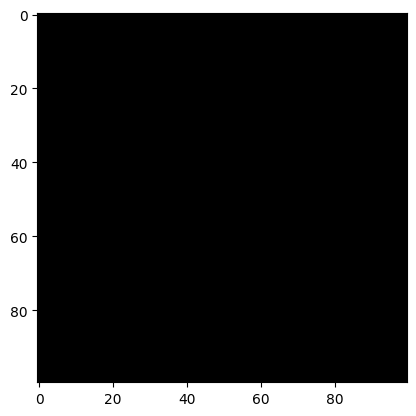

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
# matplotlib
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interactive, IntSlider, Output
from IPython.display import clear_output, display

# %matplotlib widget 

import mediapipe as mp



img = np.zeros((100, 100), dtype=np.uint8)
plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.show()

In [5]:
# LICENSE file in the root directory of this source tree.

import os

import av
import fnmatch
import pickle
import numpy as np
import torch

import lib.data_utils.fs as fs

from functools import partial

# from lib.tracker.perspective_crop import landmarks_from_hand_pose


#from multiprocessing import Pool
#from typing import Optional, Tuple

from lib.models.model_loader import load_pretrained_model

#from lib.tracker.tracker import HandTracker, HandTrackerOpts, InputFrame, ViewData
from lib.tracker.video_pose_data import SyncedImagePoseStream

from typing import Dict, NamedTuple

#from lib.common.hand import NUM_HANDS, NUM_LANDMARKS_PER_HAND
NUM_HANDS = 2
NUM_LANDMARKS_PER_HAND = 21
NUM_FINGERTIPS_PER_HAND = 5
NUM_JOINTS_PER_HAND = 22
LEFT_HAND_INDEX = 0
RIGHT_HAND_INDEX = 1

NUM_DIGITS: int = 5
NUM_JOINT_FRAMES: int = 1 + 1 + 3 * 5  # root + wrist + finger frames * 5
DOF_PER_FINGER: int = 4

# import from lib.common.affine.py

In [6]:
import numpy as np
from scipy.spatial.transform import Rotation


def transform3(m, v):
    return transform_vec3(m, v) + m[..., :3, 3]


def transform_vec3(m, v):
    if m.ndim == 2:
        return (v.reshape(-1, 3) @ m[:3, :3].T).reshape(v.shape)
    else:
        return (m[..., :3, :3] @ v[..., None]).squeeze(-1)


def normalized(v: np.ndarray, axis: int = -1, eps: float = 5.43e-20) -> np.ndarray:
    d = np.maximum(eps, (v * v).sum(axis=axis, keepdims=True) ** 0.5)
    return v / d


def skew_matrix(v: np.ndarray) -> np.ndarray:
    res = np.array(
        [[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]], dtype=v.dtype
    )
    return res


def from_two_vectors(a_orig: np.ndarray, b_orig: np.ndarray) -> np.ndarray:
    a = normalized(a_orig)
    b = normalized(b_orig)
    v = np.cross(a, b)
    s = np.linalg.norm(v)
    c = np.dot(a, b)
    v_mat = skew_matrix(v)

    rot = np.eye(3, 3) + v_mat + np.matmul(v_mat, v_mat) * (1 - c) / (max(s * s, 1e-15))

    return rot


def make_look_at_matrix(
    orig_world_to_eye: np.ndarray,
    center: np.ndarray,
    camera_angle: float = 0,
) -> np.ndarray:
    """
    args:
        orig_world_to_eye:  world to eye transform
            inverse of camera.camera_to_world_xf
        center:  np.array. (3,)
            3D world coordinate of center of the object of interest
        camera_angle: the angle of the camera
            camera_angle: how the camera is oriented physically so that we can rotate the object of
            interest to the 'upright' direction
    """
    center_local = transform3(orig_world_to_eye, center)
    z_dir_local = center_local / np.linalg.norm(center_local)
    delta_r_local = from_two_vectors(
        np.array([0, 0, 1], dtype=center.dtype), z_dir_local
    )
    orig_eye_to_world = np.linalg.inv(orig_world_to_eye)

    new_eye_to_world = orig_eye_to_world.copy()
    new_eye_to_world[0:3, 0:3] = orig_eye_to_world[0:3, 0:3] @ delta_r_local

    # Locally rotate the z axis to align with the camera angle
    z_local_rot = Rotation.from_euler("z", camera_angle, degrees=True).as_matrix()
    new_eye_to_world[0:3, 0:3] = new_eye_to_world[0:3, 0:3] @ z_local_rot

    return np.linalg.inv(new_eye_to_world)



# import from lib.common.camera

In [7]:
# Copyright (c) Meta Platforms, Inc. and affiliates.
# All rights reserved.

# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.

import abc
import json
import math
from typing import NamedTuple, Sequence, Tuple, Type

import numpy as np
from typing_extensions import Protocol, runtime_checkable


class CameraProjection(Protocol):
    """
    Defines a projection from a 3D `xyz` direction or point to 2D.
    """

    @classmethod
    @abc.abstractmethod
    def project(cls, v):
        """
        Project a 3d vector in eye space down to 2d.
        """
        ...

    @classmethod
    @abc.abstractmethod
    def unproject(cls, p):
        """
        Unproject a 2d point to a unit-length vector in eye space.

        `project(unproject(p)) == p`
        `unproject(project(v)) == v / |v|`
        """
        ...


@runtime_checkable
class DistortionModel(Protocol):
    @abc.abstractmethod
    def evaluate(self: Sequence[float], p: np.ndarray) -> np.ndarray:
        """
        Arguments
        ---------
        p: ndarray[..., 2]
            Array of 2D points, of arbitrary batch shape.

        Returns
        -------
        q: ndarray[..., 2]
            Distorted points with same shape as input
        """
        ...


class PerspectiveProjection(CameraProjection):
    @staticmethod
    def project(v):
        # map to [x/z, y/z]
        assert v.shape[-1] == 3
        return v[..., :2] / v[..., 2, None]

    @staticmethod
    def unproject(p):
        # map to [u,v,1] and renormalize
        assert p.shape[-1] == 2
        x, y = np.moveaxis(p, -1, 0)
        v = np.stack((x, y, np.ones(shape=x.shape, dtype=x.dtype)), axis=-1)
        v = normalized(v, axis=-1)
        return v


class ArctanProjection(CameraProjection):
    @staticmethod
    def project(p, eps: float = 2.0**-128):
        
        """
        eye space to projected space
        It seems arctan projection is same as equid
        """
        
        
        assert p.shape[-1] == 3
        x, y, z = np.moveaxis(p, -1, 0)
        r = np.sqrt(x * x + y * y)
        s = np.arctan2(r, z) / np.maximum(r, eps)
        return np.stack((x * s, y * s), axis=-1)

    @staticmethod
    def unproject(uv):
        assert uv.shape[-1] == 2
        u, v = np.moveaxis(uv, -1, 0)
        r = np.sqrt(u * u + v * v)
        c = np.cos(r)
        s = np.sinc(r / np.pi)
        return np.stack([u * s, v * s, c], axis=-1)


class NoDistortion(NamedTuple):
    """
    A trivial distortion model that does not distort the incoming rays.
    """

    def evaluate(self, p: np.ndarray) -> np.ndarray:
        return p


class Fisheye62CameraModel(NamedTuple):
    """
    Fisheye62CameraModel model, with 6 radial and 2 tangential coeffs.
    """

    k1: float
    k2: float
    k3: float
    k4: float
    p1: float
    p2: float
    k5: float
    k6: float

    def evaluate(self: Sequence[float], p: np.ndarray) -> np.ndarray:
        k1, k2, k3, k4, p1, p2, k5, k6 = self
        # radial component
        r2 = (p * p).sum(axis=-1, keepdims=True)
        r2 = np.clip(r2, -np.pi**2, np.pi**2)
        r4 = r2 * r2
        r6 = r2 * r4
        r8 = r4 * r4
        r10 = r4 * r6
        r12 = r6 * r6
        radial = 1 + k1 * r2 + k2 * r4 + k3 * r6 + k4 * r8 + k5 * r10 + k6 * r12
        uv = p * radial

        # tangential component
        x, y = uv[..., 0], uv[..., 1]
        x2 = x * x
        y2 = y * y
        xy = x * y
        r2 = x2 + y2
        x += 2 * p2 * xy + p1 * (r2 + 2 * x2)
        y += 2 * p1 * xy + p2 * (r2 + 2 * y2)
        return np.stack((x, y), axis=-1)


    def undistort(self, q: np.ndarray, solver_iters: int = 50) -> np.ndarray :
        """
        Undistorts 2D points using the fisheye radial distortion parameters.

        Arguments:
        ----------
        distorted_points : ndarray[..., 2]
            Array of distorted 2D points to be undistorted.

        Returns:
        --------

        undistorted_points : ndarray[..., 2]
            Array of undistorted 2D points.
        """
        k1, k2, k3, k4, p1, p2, k5, k6 = self
        x_distorted = q[..., 0]
        y_distorted = q[..., 1]

        # Initial guess: the distorted points as undistorted
        x_undistorted = x_distorted.copy()
        y_undistorted = y_distorted.copy()

        for _ in range(5):  # Perform 5 iterations to refine the undistorted coordinates
            r2 = x_undistorted**2 + y_undistorted**2
            radial_factor = (
                1 + k1*r2 + k2 * r2**2 + 
                k3 * r2**3 + k4 * r2**4 +
                k5 * r2**5 + k6 * r2**6
            )

            # Update the undistorted points by scaling the distorted points
            x_undistorted = x_distorted / radial_factor
            y_undistorted = y_distorted / radial_factor

        return np.stack([x_undistorted, y_undistorted], axis=-1)

# ---------------------------------------------------------------------
# API Conventions and naming
#
# Points have the xyz or uv components in the last axis, and may have
# arbitrary batch shapes. ([...,2] for 2d and [...,3] for 3d).
#
# v
#    3D xyz position in eye space, usually unit-length.
# p
#    projected uv coordinates: `p = project(v)`
# q
#    distorted uv coordinates: `q = distort(p)`
# w
#    window coordinates: `q = q * f + [cx, cy]`
#
# A trailing underscore (e.g. `p_`, `q_`) should be read as "hat", and
# generally indicates an approximation to another value.
# ---------------------------------------------------------------------


class CameraModel(CameraProjection, abc.ABC):
    """
    Parameters
    ----------
    width, height : int
        Size of the sensor window

    f : float or tuple(float, float)
        Focal length

    c : tuple(float, float)
        Optical center in window coordinates

    distort_coeffs
        Forward distortion coefficients (eye -> window).

        If this is an instance of DistortionModel, it will be used as-is
        (even if it's a different polynomial than this camera model
        would normally use.) If it's a simple tuple or array, it will
        used as coefficients for `self.distortion_model`.

    camera_to_world_xf : np.ndarray
        Camera's position and orientation in world space, represented as
        a 3x4 or 4x4 matrix.

        The matrix be a rigid transform (only rotation and translation).

        You can change a camera's camera_to_world_xf after construction by
        assigning to or modifying this matrix.

    Attributes
    ----------
    Most attributes are the same as constructor parameters.

    distortion_model
        Class attribute giving the distortion model for new instances.

    """

    width: int
    height: int

    f: Tuple[float, float]
    c: Tuple[float, float]

    camera_to_world_xf: np.ndarray

    distortion_model: Type[DistortionModel]
    distort: DistortionModel

    def __init__(
        self,
        width,
        height,
        f,
        c,
        distort_coeffs,
        camera_to_world_xf=None,
    ):  # pylint: disable=super-init-not-called (see issue 4790 on pylint github)
        self.width = width
        self.height = height

        # f can be either a scalar or (fx,fy) pair. We only fit scalars,
        # but may load (fx, fy) from a stored file.
        self.f = tuple(np.broadcast_to(f, 2))
        self.c = tuple(c)

        if camera_to_world_xf is None:
            self.camera_to_world_xf = np.eye(4)
        else:
            self.camera_to_world_xf = camera_to_world_xf

        if isinstance(distort_coeffs, DistortionModel):
            self.distort = distort_coeffs
        else:
            self.distort = self.distortion_model(*distort_coeffs)

    def __repr__(self):
        return (
            f"{type(self).__name__}({self.width}x{self.height}, f={self.f} c={self.c}"
        )

    def copy(self, camera_to_world_xf=None):
        """Return a copy of this camera

        Arguments
        ---------
        camera_to_world_xf : 4x4 np.ndarray
            Optional new camera_to_world_xf for the new camera model.
            Default is to copy this camera's camera_to_world_xf.
        """
        return self.crop(0, 0, self.width, self.height, camera_to_world_xf=camera_to_world_xf)

    def world_to_eye(self, v):
        """
        Apply camera camera_to_world_xf to points `v` to get eye coords
        """
        return transform_vec3(self.camera_to_world_xf.T, v - self.camera_to_world_xf[:3, 3])

    def eye_to_world(self, v):
        """
        Apply inverse camera camera_to_world_xf to eye points `v` to get world coords
        """
        return transform3(self.camera_to_world_xf, v)

    def eye_to_window(self, v):
        """Project eye coordinates to 2d window coordinates"""
        p = self.project(v)
        q = self.distort.evaluate(p)
        return q * self.f + self.c

    def window_to_eye(self, w):
        """Unproject 2d window coordinates to unit-length 3D eye coordinates"""
        q = (np.asarray(w) - self.c) / self.f
        # assert isinstance(
        #     self.distort, NoDistortion
        # ), "Only unprojection for NoDistortion camera is supported"
        return self.unproject(q)

    def crop(
        self,
        src_x,
        src_y,
        target_width,
        target_height,
        scale=1,
        camera_to_world_xf=None,
    ):
        """
        Return intrinsics for a crop of the sensor image.

        No scaling is applied; this just returns the model for a sub-
        array of image data. (Or for a larger array, if (x,y)<=0 and
        (width, height) > (self.width, self.height).

        To do both cropping and scaling, use :meth:`subrect`

        Parameters
        ----------
        x, y, width, height
            Location and size in this camera's window coordinates
        """
        return type(self)(
            target_width,
            target_height,
            np.asarray(self.f) * scale,
            (np.array(self.c) - (src_x, src_y) + 0.5) * scale - 0.5,
            self.distort,
            self.camera_to_world_xf if camera_to_world_xf is None else camera_to_world_xf,
        )


# Camera models
# =============


class PinholePlaneCameraModel(PerspectiveProjection, CameraModel):
    distortion_model = NoDistortion

    def uv_to_window_matrix(self):
        """Return the 3x3 intrinsics matrix"""
        return np.array(
            [[self.f[0], 0, self.c[0]], [0, self.f[1], self.c[1]], [0, 0, 1]]
        )


class Fisheye62CameraModel(ArctanProjection, CameraModel):
    distortion_model = Fisheye62CameraModel
    
    @staticmethod
    def unproject(uv):
        """
        Unproject 2D window coordinates to unit-length 3D eye coordinates.
        
        This implementation assumes that `uv` are in normalized image coordinates
        (i.e., after subtracting the principal point and dividing by the focal length).
        """
        assert uv.shape[-1] == 2, "Input should be a 2D point or array of 2D points."

        u, v = np.moveaxis(uv, -1, 0)
        r = np.sqrt(u * u + v * v)

        # Compute the angle of the ray in radians
        theta = np.arctan(r)

        # Compute the normalized z component (cosine of theta)
        z = np.cos(theta)

        # Compute the radial distance on the image plane
        r_normalized = np.sin(theta)

        # Normalize u and v by their radial distance to get the x and y components
        x = u * r_normalized / np.maximum(r, 1e-12)
        y = v * r_normalized / np.maximum(r, 1e-12)

        return np.stack([x, y, z], axis=-1)


def read_camera_from_json(js):
    if isinstance(js, str):
        js = json.loads(js)
    js = js.get("Camera", js)

    width = js["ImageSizeX"]
    height = js["ImageSizeY"]
    model = js["DistortionModel"]
    fx = js["fx"]
    fy = js["fy"]
    cx = js["cx"]
    cy = js["cy"]

    if model == "PinholePlane":
        cls = PinholePlaneCameraModel
    elif model == "FishEye62":
        cls = Fisheye62CameraModel

    distort_params = cls.distortion_model._fields
    coeffs = [js[name] for name in distort_params]

    return cls(width, height, (fx, fy), (cx, cy), coeffs)


# import from lib.common.crop.py

In [8]:

from typing import Tuple


import numpy as np


def gen_intrinsics_from_bounding_pts(
    pts_eye: np.ndarray, image_w: int, image_h: int, min_focal: float = 5
) -> Tuple[np.ndarray, np.ndarray]:
    pts_ndc = pts_eye[..., 0:2] / pts_eye[..., 2:]
    img_size = np.array([image_w, image_h], dtype=pts_eye.dtype)
    # Given our convention, we need to shift one pixel before dividing by 2.
    cx_cy = (img_size - 1) / 2
    fx_fy = cx_cy / np.absolute(pts_ndc).max()

    # Some sanity checks
    if np.any(pts_eye[..., 2:] < 0.0001) or np.any(fx_fy < min_focal):
        raise ValueError("Unable to create crop camera", fx_fy)

    return fx_fy, cx_cy


def gen_crop_parameters_from_points(
    camera_orig: CameraModel,
    pts_world,
    new_image_size: Tuple[int, int],
    mirror_img_x: bool,
    camera_angle: float = 0,
    focal_multiplier: float = 0.95,
) -> PinholePlaneCameraModel:
    """
    Given the original camera transform and a list of 3D points in the world space,
    compute the new perspective camera that makes sure after projection all the points
    can be projected inside the image.

    Auguments:
    * camera_orig: the original camera used for generating an image. The returned camera
        will have the same position but different rotation and intrinsics parameters.
    * pts_world: points in the world space that must be projected inside the image by
        the generated world to eye transform and intrinsics.
    * new_image_size: target image size
    * mirror_img_x: whether to flip the image. A typical use case is we usually mirror the
        right hand images so that a model need to handle left hand data only
    * camera_angle: how the camera is oriented physically so that we can rotate the object of
        interest to the 'upright' direction
    * focal_multiplier: when less than 1, we are zooming out a little. The effect on the image
        is some margin will be left at the boundary.
    """
    orig_world_to_eye_xf = np.linalg.inv(camera_orig.camera_to_world_xf)

    crop_center = (pts_world.min(axis=0) + pts_world.max(axis=0)) / 2.0
    new_world_to_eye = make_look_at_matrix(
        orig_world_to_eye_xf, crop_center, camera_angle
    )
    if mirror_img_x:
        mirrorx = np.eye(4, dtype=np.float32)
        mirrorx[0, 0] = -1
        new_world_to_eye = mirrorx @ new_world_to_eye

    fx_fy, cx_cy = gen_intrinsics_from_bounding_pts(
        transform3(new_world_to_eye, pts_world),
        new_image_size[0],
        new_image_size[1],
    )
    fx_fy = focal_multiplier * fx_fy

    return PinholePlaneCameraModel(
        width=new_image_size[0],
        height=new_image_size[1],
        f=fx_fy,
        c=cx_cy,
        distort_coeffs=[],
        camera_to_world_xf=np.linalg.inv(new_world_to_eye),
    )


# import from lib.tracker.tracking_result 

In [9]:
from typing import Dict, NamedTuple

class SingleHandPose(NamedTuple):
    """
    A hand pose is composed of two fields:
    1) joint angles where # joints == # DoFs
    2) root-to-world rigid wrist transformation
    """

    joint_angles: np.ndarray = np.zeros(NUM_JOINTS_PER_HAND, dtype=np.float32)
    wrist_xform: np.ndarray = np.eye(4, dtype=np.float32)
    hand_confidence: float = 1.0


# Tracking result maps from hand_index to hand_pose
class TrackingResult(NamedTuple):
    hand_poses: Dict[int, SingleHandPose] = {}
    num_views: Dict[int, int] = {}
    predicted_scales: Dict[int, float] = {}


# import from lib.common.crop

In [10]:

from typing import Tuple

# import lib.common.camera as camera

import numpy as np

# from . import affine

def gen_intrinsics_from_bounding_pts(
    pts_eye: np.ndarray, image_w: int, image_h: int, min_focal: float = 5
) -> Tuple[np.ndarray, np.ndarray]:
    pts_ndc = pts_eye[..., 0:2] / pts_eye[..., 2:]
    img_size = np.array([image_w, image_h], dtype=pts_eye.dtype)
    # Given our convention, we need to shift one pixel before dividing by 2.
    cx_cy = (img_size - 1) / 2
    fx_fy = cx_cy / np.absolute(pts_ndc).max()

    # Some sanity checks
    if np.any(pts_eye[..., 2:] < 0.0001) or np.any(fx_fy < min_focal):
        raise ValueError("Unable to create crop camera", fx_fy)

    return fx_fy, cx_cy


def gen_crop_parameters_from_points(
    camera_orig: CameraModel,
    pts_world,
    new_image_size: Tuple[int, int],
    mirror_img_x: bool,
    camera_angle: float = 0,
    focal_multiplier: float = 0.95,
) -> PinholePlaneCameraModel:
    """
    Given the original camera transform and a list of 3D points in the world space,
    compute the new perspective camera that makes sure after projection all the points
    can be projected inside the image.

    Auguments:
    * camera_orig: the original camera used for generating an image. The returned camera
        will have the same position but differet rotation and intrinsics parameters.
    * pts_world: np.array. (21, 3) or (42, 3) or (63, 3)
        points in the world space that must be projected inside the image by
        the generated world to eye transform and intrinsics.
    * new_image_size: target image size
    * mirror_img_x: whether to flip the image. A typical use case is we usually mirror the
        right hand images so that a model need to handle left hand data only
    * camera_angle: how the camera is oriented physically so that we can rotate the object of
        interest to the 'upright' direction
    * focal_multiplier: when less than 1, we are zooming out a little. The effect on the image
        is some margin will be left at the boundary.
    """
    orig_world_to_eye_xf = np.linalg.inv(camera_orig.camera_to_world_xf)

    crop_center = (pts_world.min(axis=0) + pts_world.max(axis=0)) / 2.0
    new_world_to_eye = make_look_at_matrix(
        orig_world_to_eye_xf, crop_center, camera_angle
    )
    if mirror_img_x:
        mirrorx = np.eye(4, dtype=np.float32)
        mirrorx[0, 0] = -1
        new_world_to_eye = mirrorx @ new_world_to_eye


    fx_fy, cx_cy = gen_intrinsics_from_bounding_pts(
        transform3(new_world_to_eye, pts_world),
        new_image_size[0],
        new_image_size[1],
    )
    
    fx_fy = focal_multiplier * fx_fy

    return PinholePlaneCameraModel(
        width=new_image_size[0],
        height=new_image_size[1],
        f=fx_fy,
        c=cx_cy,
        distort_coeffs=[],
        camera_to_world_xf=np.linalg.inv(new_world_to_eye),
    )


# import from lib.tracker.perspective_crop.py

In [11]:
# Copyright (c) Meta Platforms, Inc. and affiliates.
# All rights reserved.

# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.

from typing import Dict, List, Optional, Tuple

# import lib.common.camera as camera
import numpy as np
import torch
#from lib.common.crop import gen_crop_parameters_from_points
from lib.common.hand import HandModel, NUM_JOINTS_PER_HAND, RIGHT_HAND_INDEX
from lib.common.hand_skinning import skin_landmarks

#from .tracking_result import SingleHandPose

def neutral_joint_angles(up: HandModel, lower_factor: float = 0.5) -> torch.Tensor:
    joint_limits = up.joint_limits
    assert joint_limits is not None
    return joint_limits[..., 0] * lower_factor + joint_limits[..., 1] * (
        1 - lower_factor
    )


def skin_landmarks_np(
    hand_model: HandModel,
    joint_angles: np.ndarray,
    wrist_transforms: np.ndarray,
) -> np.ndarray:
    landmarks = skin_landmarks(
        hand_model,
        torch.from_numpy(joint_angles).float(),
        torch.from_numpy(wrist_transforms).float(),
    )
    return landmarks.numpy()


def landmarks_from_hand_pose(
    hand_model: HandModel, hand_pose: SingleHandPose, hand_idx: int
) -> np.ndarray:
    """
    Compute 3D landmarks in the world space given the hand model and hand pose.
    """
    xf = hand_pose.wrist_xform.copy()
    # This function expects the user hand model to be a left hand.
    if hand_idx == RIGHT_HAND_INDEX:
        xf[:, 0] *= -1
    landmarks = skin_landmarks_np(hand_model, hand_pose.joint_angles, xf)
    return landmarks


def rank_hand_visibility_in_cameras(
    cameras: List[CameraModel],
    hand_model: HandModel,
    hand_pose: SingleHandPose,
    hand_idx: int,
    min_required_vis_landmarks: int,
) -> List[int]:
    landmarks_world = landmarks_from_hand_pose(
        hand_model, hand_pose, hand_idx
    )
    
    # list of number of 3D keypoints that project into views for each camera
    n_landmarks_in_view = []
    
    # list of camera indices that can see enough hand points
    ranked_cam_indices = []
    for cam_idx, camera in enumerate(cameras):
        # (21, 3)
        landmarks_eye = camera.world_to_eye(landmarks_world)
        
        # (21, 2)
        landmarks_win2 = camera.eye_to_window(landmarks_eye)
        
        n_visible = (
            (landmarks_win2[..., 0] >= 0)
            & (landmarks_win2[..., 0] <= camera.width - 1)
            & (landmarks_win2[..., 1] >= 0)
            & (landmarks_win2[..., 1] <= camera.height - 1)
            & (landmarks_eye[..., 2] > 0)
        ).sum()

        n_landmarks_in_view.append(n_visible)
        # Only push the cameras that can see enough hand points
        if n_visible >= min_required_vis_landmarks:
            ranked_cam_indices.append(cam_idx)

    # print("ranked_cam_indices", ranked_cam_indices)
    # print("n_landmarks_in_view", n_landmarks_in_view)   

    #  Favor the view that sees more landmarks
    ranked_cam_indices.sort(
        reverse=True,
        key=lambda x: n_landmarks_in_view[x],
    )
    # print("ranked_cam_indices", ranked_cam_indices)
    return ranked_cam_indices


def _get_crop_points_from_hand_pose(
    hand_model: HandModel,
    gt_hand_pose: SingleHandPose,
    hand_idx: int,
    num_crop_points: int,
) -> np.ndarray:
    '''
    args :
        hand_model : HandModel
        
        gt_hand_pose : SingleHandPose
        
        hand_idx : int

        num_crop_points : int
            ㅅㅂ WTF does num_crop_points do?
    
    return :
        np.ndarray of shape (num_crop_points, 3)
        each row is a 3D keypoint in the 3D coordinate
        (not sure world space or eye space)
    '''
    assert num_crop_points in [21, 42, 63]
    neutral_hand_pose = SingleHandPose(
        joint_angles=neutral_joint_angles(hand_model).numpy(),
        wrist_xform=gt_hand_pose.wrist_xform,
    )
    open_hand_pose = SingleHandPose(
        joint_angles=np.zeros(NUM_JOINTS_PER_HAND, dtype=np.float32),
        wrist_xform=gt_hand_pose.wrist_xform,
    )

    crop_points = []
    crop_points.append(landmarks_from_hand_pose(
        hand_model, gt_hand_pose, hand_idx)
    )
    if num_crop_points > 21:
        crop_points.append(
            landmarks_from_hand_pose(
                hand_model, neutral_hand_pose, hand_idx
            )
        )
    if num_crop_points > 42:
        crop_points.append(
            landmarks_from_hand_pose(
                hand_model, open_hand_pose, hand_idx
            )
        )
    
    result = np.concatenate(crop_points, axis=0)
    # print("crop_points", result.shape)
    
    return result

def gen_crop_cameras_from_pose(
    cameras: List[CameraModel],
    camera_angles: List[float],
    hand_model: HandModel,
    hand_pose: SingleHandPose,
    hand_idx: int,
    num_crop_points: int,
    new_image_size: Tuple[int, int],
    max_view_num: Optional[int] = None,
    sort_camera_index: bool = False,
    focal_multiplier: float = 0.95,
    mirror_right_hand: bool = True,
    min_required_vis_landmarks: int = 19,
) -> Dict[int, PinholePlaneCameraModel]:
    
    crop_cameras: Dict[int, PinholePlaneCameraModel] = {}

    # keypoints coordinates in the world space
    crop_points = _get_crop_points_from_hand_pose(
        hand_model,
        hand_pose,
        hand_idx,
        num_crop_points,
    )
    
    # list of camera indices that can see enough hand points
    # sorted by the number of landmarks that can be seen, descending
    cam_indices = rank_hand_visibility_in_cameras(
        cameras=cameras,
        hand_model=hand_model,
        hand_pose=hand_pose,
        hand_idx=hand_idx,
        min_required_vis_landmarks=min_required_vis_landmarks,
    )

    # cam_indices is sorted by the number of landmarks that can be seen, descending
    # if sort_camera_index is True, then sort cam_indices
    if sort_camera_index:
        cam_indices = sorted(cam_indices)


    for cam_idx in cam_indices:
        crop_cameras[cam_idx] = gen_crop_parameters_from_points(
            cameras[cam_idx],
            crop_points,
            new_image_size,
            mirror_img_x=(mirror_right_hand and hand_idx == 1),
            camera_angle=camera_angles[cam_idx],
            focal_multiplier=focal_multiplier,
        )
        if len(crop_cameras) == max_view_num:
            break

    return crop_cameras


# import from tracker.py

In [12]:
# tracker.py

from dataclasses import dataclass
from typing import Dict, List, Optional

import cv2

# import lib.common.camera as camera
import numpy as np
import torch


from lib.common.hand import HandModel, NUM_HANDS, scaled_hand_model

from lib.data_utils import bundles

from lib.models.regressor import RegressorOutput
from lib.models.umetrack_model import InputFrameData, InputFrameDesc, InputSkeletonData


MM_TO_M = 0.001
M_TO_MM = 1000.0
MIN_OBSERVED_LANDMARKS = 21
CONFIDENCE_THRESHOLD = 0.5
MAX_VIEW_NUM = 2


@dataclass
class ViewData:
    image: np.ndarray
    camera: CameraModel
    camera_angle: float


@dataclass
class InputFrame:
    views: List[ViewData]

@dataclass
class HandTrackerOpts:
    
    num_crop_points: int = 63
    # can be [21, 42, 63]
    # when performing perspective crop,
    # 21: crop along detected pose ?
    # 42: crop along detected pose + open pose
    # 63: crop along detected pose + open pose + neutral pose
    
    enable_memory: bool = True
    
    use_stored_pose_for_crop: bool = True
    
    hand_ratio_in_crop: float = 0.95
    
    min_required_vis_landmarks: int = 19

def _warp_image(
    src_camera: CameraModel,
    dst_camera: CameraModel,
    src_image: np.ndarray,
    interpolation: int = cv2.INTER_LINEAR,
    depth_check: bool = True,
) -> np.ndarray:
    W, H = dst_camera.width, dst_camera.height
    px, py = np.meshgrid(np.arange(W), np.arange(H))
    dst_win_pts = np.column_stack((px.flatten(), py.flatten()))


    # print("dst_camera.dostort", type(dst_camera.distort))
    # print("dst_camera.distort", dst_camera.distort)
    # print(isinstance(dst_camera.distort, NoDistortion))

    dst_eye_pts = dst_camera.window_to_eye(dst_win_pts)
    world_pts = dst_camera.eye_to_world(dst_eye_pts)
    src_eye_pts = src_camera.world_to_eye(world_pts)
    src_win_pts = src_camera.eye_to_window(src_eye_pts)

    # Mask out points with negative z coordinates
    if depth_check:
        mask = src_eye_pts[:, 2] < 0
        src_win_pts[mask] = -1

    src_win_pts = src_win_pts.astype(np.float32)

    map_x = src_win_pts[:, 0].reshape((H, W))
    map_y = src_win_pts[:, 1].reshape((H, W))

    warped_image = cv2.remap(src_image, map_x, map_y, interpolation)
    
    
    return warped_image

class HandTracker:
    def __init__(self, model, opts: HandTrackerOpts) -> None:
        self._device: str = "cuda" if torch.cuda.device_count() else "cpu"
        
        self._model = model
        self._model.to(self._device)

        self._input_size = np.array(self._model.getInputImageSizes())
        self._num_crop_points = opts.num_crop_points
        self._enable_memory = opts.enable_memory
        self._hand_ratio_in_crop: float = opts.hand_ratio_in_crop
        self._min_required_vis_landmarks: int = opts.min_required_vis_landmarks
        self._valid_tracking_history = np.zeros(2, dtype=bool)

    def reset_history(self) -> None:
        self._valid_tracking_history[:] = False
        
    def gen_crop_cameras_from_stereo_camera_with_window_hand_pose(
        self,
        camera_left: CameraModel,
        camera_right: CameraModel,
        window_hand_pose_left: Dict[int, np.ndarray],
        window_hand_pose_right: Dict[int, np.ndarray],
    ) :
        """
        window coordinate : pixel coordinate
        get crop_cameras from camera, view and 2D pose
        
        Assumstions :
            camera is stereo camera. 
            2D Hand pose is already valid.
        args :
            camera_left  : camera.CameraModel
            camera_right : camera.CameraModel
            window_hand_pose_left  : Dict[int, np.ndarray]
            window_hand_pose_right : Dict[int, np.ndarray]
        """
        crop_camera_dict: Dict[int, Dict[int, PinholePlaneCameraModel]] = {}
        
        # perform for left camera
        camera_left_world_to_eye = np.linalg.inv(camera_left.camera_to_world_xf)
        for hand_idx, window_hand_pose in window_hand_pose_left.items():
            # hand_idx      left : 0  right : 1
            # window_hand_pose : np.array, (21, 2). window coordinate
            crop_camera_dict_per_hand: Dict[int, PinholePlaneCameraModel] = {}
            
            world_hand_pose = camera_left.eye_to_world(
                camera_left.window_to_eye(window_hand_pose[:, :2])
            )   
            
            world_hand_pose_center = (
                world_hand_pose.min(axis=0) + world_hand_pose.max(axis=0)
            ) / 2
            
            new_world_to_eye = make_look_at_matrix(
                camera_left_world_to_eye,
                world_hand_pose_center,
                0
            )
            if hand_idx == 1:
                mirrorx = np.eye(4, dtype=np.float32)
                mirrorx[0, 0] = -1
                new_world_to_eye = mirrorx @ new_world_to_eye
            
            fx_fy, cx_cy = gen_intrinsics_from_bounding_pts(
                transform3(new_world_to_eye, world_hand_pose),
                self._input_size[0], self._input_size[1],
            )
            fx_fy = self._hand_ratio_in_crop * fx_fy
            
            new_cam = PinholePlaneCameraModel(
                width=self._input_size[0],
                height=self._input_size[1],
                f=fx_fy,
                c=cx_cy,
                distort_coeffs = [],
                camera_to_world_xf=np.linalg.inv(new_world_to_eye),
            )
            crop_camera_dict_per_hand[hand_idx] = new_cam
            crop_camera_dict[hand_idx] = crop_camera_dict_per_hand
            
        camera_right_world_to_eye = np.linalg.inv(camera_right.camera_to_world_xf)
        for hand_idx, window_hand_pose in window_hand_pose_right.items():
            crop_camera_dict_per_hand = {}
            
            world_hand_pose = camera_right.eye_to_world(
                camera_right.window_to_eye(window_hand_pose[:, :2])
            )   
            
            world_hand_pose_center = (
                world_hand_pose.min(axis=0) + world_hand_pose.max(axis=0)
            ) / 2
            
            new_world_to_eye = make_look_at_matrix(
                camera_right_world_to_eye,
                world_hand_pose_center,
                0
            )
            if hand_idx == 1:
                mirrorx = np.eye(4, dtype=np.float32)
                mirrorx[0, 0] = -1
                new_world_to_eye = mirrorx @ new_world_to_eye
            
            fx_fy, cx_cy = gen_intrinsics_from_bounding_pts(
                transform3(new_world_to_eye, world_hand_pose),
                self._input_size[0], self._input_size[1],
            )
            fx_fy = self._hand_ratio_in_crop * fx_fy
            
            new_cam = PinholePlaneCameraModel(
                width=self._input_size[0],
                height=self._input_size[1],
                f=fx_fy,
                c=cx_cy,
                distort_coeffs = [],
                camera_to_world_xf=np.linalg.inv(new_world_to_eye),
            )
            crop_camera_dict_per_hand[hand_idx] = new_cam
            if hand_idx in crop_camera_dict :
                crop_camera_dict[hand_idx].update(crop_camera_dict_per_hand)
            else :
                crop_camera_dict[hand_idx] = crop_camera_dict_per_hand
            
        return crop_camera_dict
            
            # fig = go.Figure()
            # fig.add_trace(go.Scatter3d(
            #     x=world_hand_pose[:, 0], y=world_hand_pose[:, 1], z=world_hand_pose[:, 2],
            #     mode='markers',
            #     marker=dict(size=5, color='blue'),
            #     name='World Hand Pose'
            # ))
            # camera_left_pos = camera_left.camera_to_world_xf[:3, 3]
            # fig.add_trace(go.Scatter3d(
            #     x=[camera_left_pos[0]], y=[camera_left_pos[1]], z=[camera_left_pos[2]],
            #     mode='markers',
            #     marker=dict(size=10, color='red', symbol='square'),
            #     name='Camera Left'
            # ))
            # camera_right_pos = camera_right.camera_to_world_xf[:3, 3]
            # fig.add_trace(go.Scatter3d(
            #     x=[camera_right_pos[0]], y=[camera_right_pos[1]], z=[camera_right_pos[2]],
            #     mode='markers',
            #     marker=dict(size=10, color='green', symbol='square'),
            #     name='Camera Right'
            # ))
            # fig.update_layout(
            #     scene=dict(
            #         xaxis_title='X',
            #         yaxis_title='Y',
            #         zaxis_title='Z',
            #         aspectmode='data'
            #     ),
            #     title='3D Visualization of World Hand Pose and Cameras'
            # )
            # fig.show()
            
            
        
    def gen_crop_cameras_analysis(
        self,
        #cameras: List[camera.CameraModel],
        input_frame,
        camera_angles: List[float],
        hand_model: HandModel,
        gt_tracking: Dict[int, SingleHandPose],
        min_num_crops: int,
    ) -> Dict[int, Dict[int, PinholePlaneCameraModel]]:
        """
        functions to analyze the crop cameras
        """
    
        cameras = [view.camera for view in input_frame.views]
        
        crop_cameras: Dict[int, Dict[int, PinholePlaneCameraModel]] = {}
        if not gt_tracking:
            return crop_cameras

        # evaluate for each detected hands.
        for hand_idx, gt_hand_pose in gt_tracking.items():
            if gt_hand_pose.hand_confidence < CONFIDENCE_THRESHOLD:
                continue

            # contains croped cameras in multi origin views for single hand
            crop_camera_dict_per_hand: Dict[int, PinholePlaneCameraModel] = {}
            
            # contains camera indexes that target hand is visible in       
            valid_cam_index_list = sorted(rank_hand_visibility_in_cameras(
                cameras,
                hand_model,
                gt_hand_pose,
                hand_idx,
                self._min_required_vis_landmarks,
            ))

            world_hand_pose = _get_crop_points_from_hand_pose(
                hand_model,
                gt_hand_pose,
                hand_idx,
                self._num_crop_points,
                #21
            )
            
            for valid_cam_idx in valid_cam_index_list:
                orig_cam = cameras[valid_cam_idx]
                orig_cam_angle = camera_angles[valid_cam_idx]
                
                orig_world_to_eye_xf = np.linalg.inv(orig_cam.camera_to_world_xf)
                
                world_hand_pose_center = (
                    world_hand_pose.min(axis=0) + world_hand_pose.max(axis=0)
                ) / 2
                
                window_hand_pose = orig_cam.eye_to_window(
                    orig_cam.world_to_eye(world_hand_pose)
                ).astype(int)
                
                
                # plt.imshow(input_frame.views[valid_cam_idx].image, cmap="gray")
                # plt.scatter(window_hand_pose[:, 0], window_hand_pose[:, 1])
                # plt.show()
                
                new_world_to_eye = make_look_at_matrix(
                    orig_world_to_eye_xf,
                    world_hand_pose_center,
                    orig_cam_angle
                )
                
                if hand_idx == 1:
                    mirrorx = np.eye(4, dtype=np.float32)
                    mirrorx[0, 0] = -1
                    new_world_to_eye = mirrorx @ new_world_to_eye
                
                fx_fy, cx_cy = gen_intrinsics_from_bounding_pts(
                    transform3(new_world_to_eye, world_hand_pose),
                    self._input_size[0], self._input_size[1],
                )
                
                fx_fy = self._hand_ratio_in_crop * fx_fy
                
                new_cam = PinholePlaneCameraModel(
                    width=self._input_size[0],
                    height=self._input_size[1],
                    f=fx_fy,
                    c=cx_cy,
                    distort_coeffs = [],
                    camera_to_world_xf=np.linalg.inv(new_world_to_eye),
                )
                crop_camera_dict_per_hand[valid_cam_idx] = new_cam

            crop_cameras[hand_idx] = crop_camera_dict_per_hand

        # Remove empty crop_cameras
        del_list = []
        for hand_idx, per_hand_crop_cameras in crop_cameras.items():
            if not per_hand_crop_cameras or len(per_hand_crop_cameras) < min_num_crops:
                del_list.append(hand_idx)
        for hand_idx in del_list:
            del crop_cameras[hand_idx]

        return crop_cameras


    def gen_crop_cameras(
        self,
        cameras: List[CameraModel],
        camera_angles: List[float],
        hand_model: HandModel,
        gt_tracking: Dict[int, SingleHandPose],
        min_num_crops: int,
    ) -> Dict[int, Dict[int, PinholePlaneCameraModel]]:
    
        '''
        args :
        return :
            crop_cameras: Dict[int, Dict[int, camera.PinholePlaneCameraModel]]
                key : hand_idx
                value : Dict[int, camera.PinholePlaneCameraModel]
                    key : cam_idx
                    value : camera.PinholePlaneCameraModel
        '''
        crop_cameras: Dict[int, Dict[int, PinholePlaneCameraModel]] = {}
        if not gt_tracking:
            return crop_cameras

        for hand_idx, gt_hand_pose in gt_tracking.items():
            if gt_hand_pose.hand_confidence < CONFIDENCE_THRESHOLD:
                continue
            crop_cameras[hand_idx] = gen_crop_cameras_from_pose(
                cameras,
                camera_angles,
                hand_model,
                gt_hand_pose,
                hand_idx,
                self._num_crop_points,
                self._input_size,
                max_view_num=MAX_VIEW_NUM,
                sort_camera_index=True,
                focal_multiplier=self._hand_ratio_in_crop,
                mirror_right_hand=True,
                min_required_vis_landmarks=self._min_required_vis_landmarks,
            )

        # Remove empty crop_cameras
        del_list = []
        for hand_idx, per_hand_crop_cameras in crop_cameras.items():
            if not per_hand_crop_cameras or len(per_hand_crop_cameras) < min_num_crops:
                del_list.append(hand_idx)
        for hand_idx in del_list:
            del crop_cameras[hand_idx]

        return crop_cameras

    def track_frame(
        self,
        sample: InputFrame,
        hand_model: HandModel,
        crop_cameras: Dict[int, Dict[int, PinholePlaneCameraModel]],
    ) -> TrackingResult:
        if not crop_cameras:
            # Frame without hands
            self.reset_history()
            return TrackingResult()

        frame_data, frame_desc, skeleton_data = self._make_inputs(
            sample, hand_model, crop_cameras
        )

    #print(skeleton_data)
        
        with torch.no_grad():
            regressor_output = bundles.to_device(
                self._model.regress_pose_use_skeleton(
                    frame_data, frame_desc, skeleton_data
                ),
                torch.device("cpu"),
            )

        tracking_result = self._gen_tracking_result(
            regressor_output,
            frame_desc.hand_idx.cpu().numpy(),
            crop_cameras,
        )
        return tracking_result

    def track_frame_analysis(
        self,
        sample: InputFrame,
        hand_model: HandModel,
        crop_cameras: Dict[int, Dict[int, PinholePlaneCameraModel]],
        gt_tracking: Dict[int, SingleHandPose],
    ):
        """
        args :
            sample : InputFrame
            hand_model : HandModel
                translation 이 밀리미터임
            crop_cameras : Dict[int, Dict[int, PinholePlaneCameraModel]]
        """
        if not crop_cameras:
            # Frame without hands
            self.reset_history()
            return TrackingResult()
        
        # < ================================================
        # < HandTracker._make_inputs
        
        image_idx = 0
        left_images = []
        intrinsics = []
        extrinsics_xf = []
        
        sample_range_n_hands = []
        hand_indices = []
        
        for hand_idx, crop_camera_info in crop_cameras.items():
            sample_range_start = image_idx
            for cam_idx, crop_camera in crop_camera_info.items():
                view_data = sample.views[cam_idx]
                
                # << ================================================
                # crop_image = _warp_image(
                #     view_data.camera,
                #     crop_camera,
                #     view_data.image
                # )
                # << _warp_image
                
                depth_check = True
                
                W, H = crop_camera.width, crop_camera.height
                px, py = np.meshgrid(np.arange(W), np.arange(H))
                dst_win_points = np.column_stack([px.flatten(), py.flatten()])
                
                dst_eye_pts = crop_camera.window_to_eye(dst_win_points)
                world_pts = crop_camera.eye_to_world(dst_eye_pts)
                src_eye_pts = view_data.camera.world_to_eye(world_pts)
                src_win_pts = view_data.camera.eye_to_window(src_eye_pts)
                
                if depth_check :
                    mask = src_eye_pts[:, 2] < 0
                    src_win_pts[mask] = -1
                    
                src_win_pts = src_win_pts.astype(np.float32)
                map_x = src_win_pts[:, 0].reshape((H, W))
                map_y = src_win_pts[:, 1].reshape((H, W))
                
                crop_image = cv2.remap(
                    view_data.image, map_x, map_y, cv2.INTER_LINEAR
                )
                
                # >> _warp_image
                # >> ================================================
                left_images.append(crop_image.astype(np.float32) / 255.0)
                intrinsics.append(crop_camera.uv_to_window_matrix())
                
                crop_world_to_eye_xf = np.linalg.inv(
                    crop_camera.camera_to_world_xf
                )
                crop_world_to_eye_xf[:3, 3] *= MM_TO_M
                extrinsics_xf.append(crop_world_to_eye_xf)
                
                image_idx += 1
                
            if image_idx > sample_range_start:
                hand_indices.append(hand_idx)
                
                sample_range_n_hands.append(np.array(
                    [sample_range_start, image_idx]
                ))
                
        # visualize
        # project gt_tracking to crop_cameras
        color_list = ['r', 'g', 'b', 'y', 'm', 'c'] 
        for hand_idx, (start_idx, end_idx) in zip(hand_indices, sample_range_n_hands):
            
            plt.figure(figsize=(20, 10))
            for i in range(start_idx, end_idx):
                plt.subplot(1, end_idx - start_idx, i - start_idx + 1)
                plt.imshow(left_images[i], cmap='gray')
                
                world_to_eye_xf = extrinsics_xf[i]  
                # meter to mm
                world_to_eye_xf[:3, 3] *= M_TO_MM
                
                eye_to_window_xf = intrinsics[i]
                
                keypoints_world = landmarks_from_hand_pose(
                    hand_model, gt_tracking[hand_idx], hand_idx
                )
                keypoints_world_homogeneous = np.hstack(
                    [keypoints_world, np.ones((len(keypoints_world), 1))]
                )
                
                keypoints_eye_homogeneous = world_to_eye_xf @ keypoints_world_homogeneous.T
                keypoints_eye = keypoints_eye_homogeneous[:3, :].T
                
                keypoints_window_homogeneous = eye_to_window_xf @ keypoints_eye.T
                keypoints_window = keypoints_window_homogeneous[:2, :].T / keypoints_window_homogeneous[2:3, :].T
                
                plt.scatter(
                    keypoints_window[:, 0],
                    keypoints_window[:, 1],
                    c=color_list[hand_idx],
                    s=50,
                    edgecolors='k',
                    linewidths=3,
                )
            plt.show()
        
        
        hand_indices = np.array(hand_indices)
        frame_data = InputFrameData(
            left_images=torch.from_numpy(np.stack(left_images)).float(),
            intrinsics=torch.from_numpy(np.stack(intrinsics)).float(),
            extrinsics_xf=torch.from_numpy(np.stack(extrinsics_xf)).float(),
        )
        frame_desc = InputFrameDesc(
            sample_range=torch.from_numpy(np.stack(
                sample_range_n_hands
            )).long(),
            memory_idx=torch.from_numpy(hand_indices).long(),
            # use memory if the hand is previously valid
            use_memory=torch.from_numpy(
                self._valid_tracking_history[hand_indices]
            ).bool(),
            hand_idx=torch.from_numpy(hand_indices).long(),
        )
        skeleton_data = None
        if hand_model is not None:
            # m -> mm
            hand_model_m = scaled_hand_model(hand_model, MM_TO_M)
            skeleton_data = InputSkeletonData(
                joint_rotation_axes=hand_model_m.joint_rotation_axes.float(),
                joint_rest_positions=hand_model_m.joint_rest_positions.float(),
            )
        frame_data, frame_desc, skeleton_data = bundles.to_device(
            (
            frame_data, frame_desc, skeleton_data
            ), self._device
        )


        # > _make_inputs
        # > ================================================
        
        # print(skeleton_data)


        with torch.no_grad():            
            regressor_output = bundles.to_device(
                self._model.regress_pose_use_skeleton(
                    frame_data, frame_desc, skeleton_data
                ),
                torch.device("cpu"),
            )

        #print(regressor_output)

        # tracking_result = self._gen_tracking_result(
        #     regressor_output,
        #     frame_desc.hand_idx.cpu().numpy(),  -> hand_indices
        #     crop_cameras,
        # )
        # return tracking_result

        # < ================================================
        # < _gen_tracking_result
        hand_indices_np = frame_desc.hand_idx.cpu().numpy()

        output_joint_angles = regressor_output.joint_angles.to("cpu").numpy()
        
        # print(output_joint_angles)

        output_wrist_xforms = regressor_output.wrist_xfs.to("cpu").numpy()
        output_wrist_xforms[..., :3, 3] *= M_TO_MM
        output_scales = None
        if regressor_output.skel_scales is not None:
            output_scales = regressor_output.skel_scales.to("cpu").numpy()

        hand_poses = {}
        num_views = {}
        predicted_scales = {}
        
        for output_idx, hand_idx in enumerate(hand_indices_np):
            raw_handpose = SingleHandPose(
                joint_angles=output_joint_angles[output_idx],
                wrist_xform=output_wrist_xforms[output_idx],
                hand_confidence=1.0,
            )
            hand_poses[hand_idx] = raw_handpose
            num_views[hand_idx] = len(crop_cameras[hand_idx])
            if output_scales is not None:
                predicted_scales[hand_idx] = output_scales[output_idx]

        for hand_idx in range(NUM_HANDS):
            hand_valid = False
            if hand_idx in hand_poses:
                self._valid_tracking_history[hand_idx] = True
                hand_valid = True
            if hand_valid:
                continue
            self._valid_tracking_history[hand_idx] = False

        return TrackingResult(
            hand_poses=hand_poses,
            num_views=num_views,
            predicted_scales=predicted_scales,
        )



    def track_frame_and_calibrate_scale(
        self,
        sample: InputFrame,
        crop_cameras: Dict[int, Dict[int, PinholePlaneCameraModel]],
    ) -> TrackingResult:
        if not crop_cameras:
            # Frame without hands
            self.reset_history()
            return TrackingResult()
        frame_data, frame_desc, _ = self._make_inputs(sample, None, crop_cameras)

        with torch.no_grad():
            regressor_output = bundles.to_device(
                self._model.regress_pose_pred_skel_scale(frame_data, frame_desc),
                torch.device("cpu"),
            )

        tracking_result = self._gen_tracking_result(
            regressor_output,
            frame_desc.hand_idx.cpu().numpy(),
            crop_cameras,
        )
        return tracking_result

    def _make_inputs(
        self,
        sample: InputFrame,
        hand_model_mm: Optional[HandModel],
        crop_cameras: Dict[int, Dict[int, PinholePlaneCameraModel]],
    ):
        '''
        args:
            sample: InputFrame
            hand_model_mm: HandModel
                mm은 밀리미터인건가?
            crop_cameras: Dict[int, Dict[int, PinholePlaneCameraModel]]
        return:
            frame_data: InputFrameData
            frame_desc: InputFrameDesc
            skeleton_data: InputSkeletonData
        '''
        image_idx = 0
        left_images = []
        intrinsics = []
        extrinsics_xf = []
        sample_range_n_hands = []
        hand_indices = []
        
        for hand_idx, crop_camera_info in crop_cameras.items():
            
            sample_range_start = image_idx
            for cam_idx, crop_camera in crop_camera_info.items():
                view_data = sample.views[cam_idx]
                crop_image = _warp_image(view_data.camera, crop_camera, view_data.image)
                left_images.append(crop_image.astype(np.float32) / 255.0)
                intrinsics.append(crop_camera.uv_to_window_matrix())

                crop_world_to_eye_xf = np.linalg.inv(crop_camera.camera_to_world_xf)
                crop_world_to_eye_xf[:3, 3] *= MM_TO_M
                extrinsics_xf.append(crop_world_to_eye_xf)

                image_idx += 1

            if image_idx > sample_range_start:
                hand_indices.append(hand_idx)
                
                # sample_range_start 부터 image_idx 까지가 특정 손에 대한 정보
                # 이걸 가지고 left_images, intrinsics 등을 인덱싱하는 듯.
                sample_range_n_hands.append(np.array(
                    [sample_range_start, image_idx]
                ))

        hand_indices = np.array(hand_indices)
        frame_data = InputFrameData(
            left_images=torch.from_numpy(np.stack(left_images)).float(),
            intrinsics=torch.from_numpy(np.stack(intrinsics)).float(),
            extrinsics_xf=torch.from_numpy(np.stack(extrinsics_xf)).float(),
        )
        frame_desc = InputFrameDesc(
            sample_range=torch.from_numpy(np.stack(sample_range_n_hands)).long(),
            memory_idx=torch.from_numpy(hand_indices).long(),
            # use memory if the hand is previously valid
            use_memory=torch.from_numpy(
                self._valid_tracking_history[hand_indices]
            ).bool(),
            hand_idx=torch.from_numpy(hand_indices).long(),
        )
        skeleton_data = None
        if hand_model_mm is not None:
            # m -> mm
            hand_model_m = scaled_hand_model(hand_model_mm, MM_TO_M)
            skeleton_data = InputSkeletonData(
                joint_rotation_axes=hand_model_m.joint_rotation_axes.float(),
                joint_rest_positions=hand_model_m.joint_rest_positions.float(),
            )
        return bundles.to_device((frame_data, frame_desc, skeleton_data), self._device)

    def _gen_tracking_result(
        self,
        regressor_output: RegressorOutput,
        hand_indices: np.ndarray,
        crop_cameras: Dict[int, Dict[int, PinholePlaneCameraModel]],
    ) -> TrackingResult:

        output_joint_angles = regressor_output.joint_angles.to("cpu").numpy()
        
        # print(output_joint_angles)


        output_wrist_xforms = regressor_output.wrist_xfs.to("cpu").numpy()
        output_wrist_xforms[..., :3, 3] *= M_TO_MM
        output_scales = None
        if regressor_output.skel_scales is not None:
            output_scales = regressor_output.skel_scales.to("cpu").numpy()

        hand_poses = {}
        num_views = {}
        predicted_scales = {}

        for output_idx, hand_idx in enumerate(hand_indices):
            raw_handpose = SingleHandPose(
                joint_angles=output_joint_angles[output_idx],
                wrist_xform=output_wrist_xforms[output_idx],
                hand_confidence=1.0,
            )
            hand_poses[hand_idx] = raw_handpose
            num_views[hand_idx] = len(crop_cameras[hand_idx])
            if output_scales is not None:
                predicted_scales[hand_idx] = output_scales[output_idx]

        for hand_idx in range(NUM_HANDS):
            hand_valid = False
            if hand_idx in hand_poses:
                self._valid_tracking_history[hand_idx] = True
                hand_valid = True
            if hand_valid:
                continue
            self._valid_tracking_history[hand_idx] = False

        return TrackingResult(
            hand_poses=hand_poses,
            num_views=num_views,
            predicted_scales=predicted_scales,
        )
        
        
    def visualize_crop_cameras(
        self,
        input_frame,
        window_hand_pose_left,
        window_hand_pose_right,
        crop_camera_dict: Dict[int, Dict[int, PinholePlaneCameraModel]],
    ):
        
        color_list = ['red', 'green'] 
        
        window_hand_pose_list = [window_hand_pose_left, window_hand_pose_right]
    
        for cam_idx, view_data in enumerate(input_frame.views) :
            print(cam_idx)
            orig_image = view_data.image
            orig_camera = view_data.camera
            window_hand_pose = window_hand_pose_list[cam_idx]
            
            # process fror left camera
            plt.figure(figsize=(20, 20))
            for idx, (hand_idx, keypoints_window) in enumerate(window_hand_pose.items()):
                keypoints_orig_eye = orig_camera.window_to_eye(keypoints_window[:, :2])
                keypoints_orig_world = orig_camera.eye_to_world(keypoints_orig_eye)
                    
                keypoints_orig_eye_reprojected = orig_camera.world_to_eye(
                    keypoints_orig_world
                )
                keypoints_orig_window_reprojected = orig_camera.eye_to_window(
                    keypoints_orig_eye_reprojected
                )
        
                # visualize original and reprojected keypoints
                plt.subplot(1, len(window_hand_pose), idx+1)
                plt.title(f"Hand {hand_idx}, green: original, red: reprojected")
                plt.imshow(orig_image, cmap='gray')
                
                plt.scatter(
                    keypoints_window[:, 0],
                    keypoints_window[:, 1],
                    c="green",
                    s=20,
                    edgecolors="k",
                    linewidths=1,
                )
                
                plt.scatter(
                    keypoints_orig_window_reprojected[:, 0],
                    keypoints_orig_window_reprojected[:, 1],
                    c="red",    
                    s=20,
                    edgecolors="k",
                    linewidths=1,
                )
   
                    
        
        
        
        
        

In [13]:
import logging
import os

logging.basicConfig(level = logging.INFO)
logger = logging.getLogger(__name__)

# model_name = "pretrained_weights.torch"
# model_path = os.path.join(".", "pretrained_models", model_name)
# model = load_pretrained_model(model_path)
# model.eval()
# tracker = HandTracker(model, HandTrackerOpts())

DATA_PATH = "sample_data/recording_00.mp4"
image_pose_stream = SyncedImagePoseStream(DATA_PATH)
hand_model = image_pose_stream._hand_pose_labels.hand_model

image_pose_list = []
for (input_frame, gt_tracking) in image_pose_stream:
    image_pose_list.append((input_frame, gt_tracking))

Opened (30 fps) video from sample_data/recording_00.mp4


In [14]:
hand_model.landmark_rest_positions

tensor([[111.0917, -48.9922,  96.2634],
        [206.7033,  -4.5554,  19.3487],
        [216.6214,  -0.2453, -10.9966],
        [200.6783,  -8.4544, -44.0461],
        [165.8968, -16.7064, -60.8536],
        [  0.0000,   0.0000,   0.0000],
        [ 68.6253, -34.6108,  51.0494],
        [ 96.1673, -43.5205,  77.0041],
        [111.3207,  -1.9627,  27.6420],
        [153.1891,  -5.5045,  25.7365],
        [180.7733,  -7.8267,  23.6301],
        [111.4067,   3.1822,   2.1328],
        [158.1213,  -0.6643,  -2.8749],
        [189.0996,  -4.3211,  -6.4626],
        [103.4250,   0.4045, -20.9553],
        [144.9484,  -5.4885, -30.8121],
        [173.6935,  -9.2730, -37.7241],
        [ 89.0581,  -7.9066, -41.4245],
        [120.3738, -14.0268, -48.4746],
        [141.5319, -16.7212, -55.0592],
        [ 93.8832, -19.6229,   6.0110]])

# Parse and analyze GT annotatio

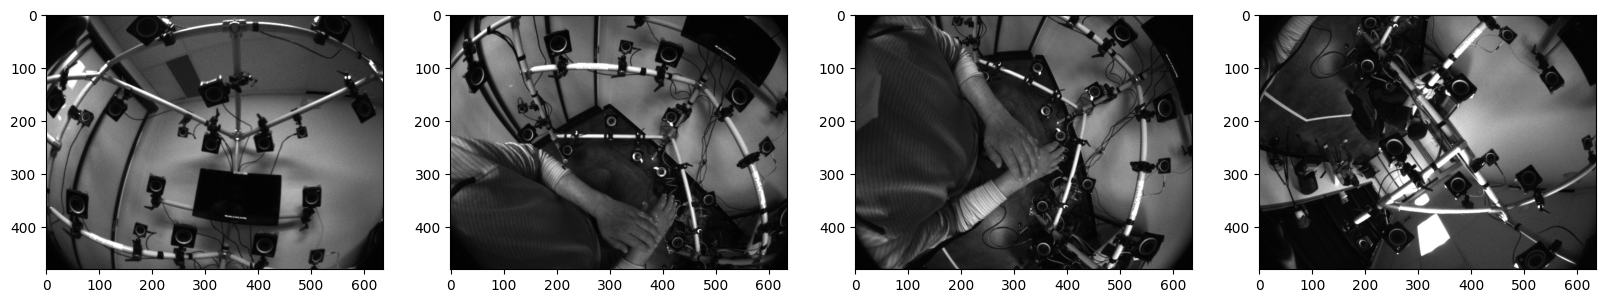

2 [[-9.03648511e-02  5.86615466e-02 -9.94179547e-01 -8.75907669e+01]
 [ 5.40197551e-01  8.41538072e-01  5.54275117e-04 -7.76728668e+01]
 [ 8.36672425e-01 -5.37003279e-01 -1.07734285e-01  2.90849342e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [15]:
idx = 20

input_frame, gt_tracking = image_pose_list[idx]

plt.figure(figsize=(20, 10))
for i, view in enumerate(input_frame.views):
    plt.subplot(1, len(input_frame.views), i+1)
    plt.imshow(view.image, cmap="gray")
plt.show()

print(len(gt_tracking), gt_tracking[0].wrist_xform)

In [21]:
type(gt_tracking[0])

lib.tracker.tracking_result.SingleHandPose

In [16]:
keypoint_pos_3D = landmarks_from_hand_pose(
    image_pose_stream._hand_pose_labels.hand_model,
    gt_tracking[0],
    0
)

In [17]:
input_frame.views[0].camera.distortion_model._fields

('k1', 'k2', 'k3', 'k4', 'p1', 'p2', 'k5', 'k6')

In [18]:
print(input_frame.views[0].camera.distortion_model.k1)
print(input_frame.views[0].camera.distortion_model.k2)
print(input_frame.views[0].camera.distortion_model.k3)
print(input_frame.views[0].camera.distortion_model.k4)
print(input_frame.views[0].camera.distortion_model.p1)
print(input_frame.views[0].camera.distortion_model.p2)
print(input_frame.views[0].camera.distortion_model.k5)
print(input_frame.views[0].camera.distortion_model.k6)

_tuplegetter(0, 'Alias for field number 0')
_tuplegetter(1, 'Alias for field number 1')
_tuplegetter(2, 'Alias for field number 2')
_tuplegetter(3, 'Alias for field number 3')
_tuplegetter(4, 'Alias for field number 4')
_tuplegetter(5, 'Alias for field number 5')
_tuplegetter(6, 'Alias for field number 6')
_tuplegetter(7, 'Alias for field number 7')


# Visualize Input (image, annotation)

In [19]:
_ = """
def create_camera_visualization(ax, camera_to_world_xf):
    camera_pos = camera_to_world_xf[:3, 3]
    camera_x = camera_to_world_xf[:3, 0]
    camera_y = camera_to_world_xf[:3, 1]
    camera_z = camera_to_world_xf[:3, 2]
    
    ax.scatter(*camera_pos, color='red', s=50, label='Camera')
    
    scale = 10
    for axis, color in zip([camera_x, camera_y, camera_z], ['red', 'green', 'blue']):
        ax.quiver(*camera_pos, *axis, length=scale, color=color, linewidth=2)

def create_keypoint_visualization(ax, keypoint_pos_3D):
    print(keypoint_pos_3D.shape)
    # keypoint_pos_3D is 21 x 3
    # ax.scatter(
    #     keypoint_pos_3D[:, 0],
    #     keypoint_pos_3D[:, 1],
    #     keypoint_pos_3D[:, 2],
    #     color='blue',
    #     label='Keypoint'
    # )
    
    color_list = [
        'blue', 'green', 'red', 'cyan', 'magenta',
        'yellow', 'black', 'white', 'purple', 'orange',
        'brown', 'pink', 'gray', 'olive', 'cyan',
        'magenta', 'yellow', 'black', 'white', 'purple',
        'orange', # 'brown', 'pink', 'gray', 'olive'
    ]
    # plot each keypoints in different color
    ax.scatter(
        keypoint_pos_3D[:, 0],
        keypoint_pos_3D[:, 1],
        keypoint_pos_3D[:, 2],
        color=color_list,
        label='Keypoint'
    )
    

def update_plot(frame_idx):    
    input_frame, gt_tracking = image_pose_list[frame_idx]
    
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    for view in input_frame.views:
        create_camera_visualization(ax, view.camera.camera_to_world_xf)

    for hand_idx, gt_hand_pose in gt_tracking.items():
        keypoint_pos_3D = landmarks_from_hand_pose(
            image_pose_stream._hand_pose_labels.hand_model,
            gt_hand_pose,
            hand_idx
        )
        create_keypoint_visualization(ax, keypoint_pos_3D)
        break


    # for hand_idx, gt_hand_pose in gt_tracking.items():
    #     wrist_xform = gt_hand_pose.wrist_xform
    #     wrist_pos = wrist_xform[:3, 3]
    #     print(wrist_pos) 
    #     ax.scatter(*wrist_pos, color='blue', s=50, label=f'Wrist {hand_idx}')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f"Camera Positions and Orientations in World Coordinate System (Frame {frame_idx})")
    ax.legend()

    # Set equal aspect ratio for all axes
    ax.set_box_aspect((np.ptp(ax.get_xlim()), np.ptp(ax.get_ylim()), np.ptp(ax.get_zlim())))

    plt.tight_layout()
    
    fig_views, axs = plt.subplots(1, len(input_frame.views), figsize=(16, 4))
    for vid, view in enumerate(input_frame.views):
        axs[vid].imshow(view.image, cmap="gray")
        axs[vid].axis('off')
    plt.tight_layout()
    
    return fig, fig_views

# Use observe instead of interactive
def on_slider_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        with output:
            clear_output(wait=True)
            # matplotlib clear output
            plt.close()
            fig, fig_views = update_plot(change['new'])
            plt.show()

slider = IntSlider(
    min=0,
    max=len(image_pose_list) - 1,
    step=1,
    value=0,
    description='Frame Index:'
)

# Observe slider changes
slider.observe(on_slider_change)

# Create an output widget to display the plot
output = Output()

# Display the slider and output
display(slider, output)

# Manually trigger the initial update
with output:
    #fig, fig_views = update_plot(0)
    #plt.show()
    pass
"""

In [20]:
# Visualize camera's position and orientation in world coordinate system using plotly
import plotly.graph_objs as go
import numpy as np
from ipywidgets import interactive, IntSlider, Output
from IPython.display import clear_output

def create_camera_visualization(camera_to_world_xf):
    # Extract camera position (translation)
    camera_pos = camera_to_world_xf[:3, 3]
    
    # Extract camera orientation (rotation)
    camera_x = camera_to_world_xf[:3, 0]
    camera_y = camera_to_world_xf[:3, 1]
    camera_z = camera_to_world_xf[:3, 2]
    
    # Create camera position marker
    camera_marker = go.Scatter3d(
        x=[camera_pos[0]], y=[camera_pos[1]], z=[camera_pos[2]],
        mode='markers',
        marker=dict(size=8, color='red'),
        name='Camera'
    )
    
    # Create camera orientation arrows
    scale = 10  # Scale factor for orientation arrows
    arrows = []
    for axis, color in zip([camera_x, camera_y, camera_z], ['red', 'green', 'blue']):
        arrows.append(go.Scatter3d(
            x=[camera_pos[0], camera_pos[0] + scale * axis[0]],
            y=[camera_pos[1], camera_pos[1] + scale * axis[1]],
            z=[camera_pos[2], camera_pos[2] + scale * axis[2]],
            mode='lines',
            line=dict(color=color, width=3),
            name=f'{color.capitalize()} axis'
        ))
    
    return [camera_marker] + arrows

# Initialize an empty figure
fig = go.Figure()

def update_plot(frame_idx):
    input_frame, gt_tracking = image_pose_list[frame_idx]
    
    # Clear previous traces
    fig.data = []
    
    # Add camera visualizations for each view
    for i, view in enumerate(input_frame.views):
        camera_vis = create_camera_visualization(
            view.camera.camera_to_world_xf
        )
        for trace in camera_vis:
            fig.add_trace(trace)

    # wrist_xform : root-to-world wrist transform
    # assume that the unit is millimeter
    for hand_idx, gt_hand_pose in gt_tracking.items():
        wrist_xform = gt_hand_pose.wrist_xform
        wrist_pos = wrist_xform[:3, 3]
        
        # Add wrist marker
        wrist_marker = go.Scatter3d(
            x=[wrist_pos[0]], y=[wrist_pos[1]], z=[wrist_pos[2]],
            mode='markers',
            marker=dict(size=8, color='blue'),
            name=f'Wrist {hand_idx}'
        )
        fig.add_trace(wrist_marker)
        
        # Add 3D hand keypoints
        
        keypoints = landmarks_from_hand_pose(
            image_pose_stream._hand_pose_labels.hand_model,
            gt_hand_pose,
            hand_idx
        )
        x_coords, y_coords, z_coords = [], [], []
        for kp in keypoints:
            x_coords.append(kp[0])
            y_coords.append(kp[1])
            z_coords.append(kp[2])
        
        keypoints_scatter = go.Scatter3d(
            x=x_coords, y=y_coords, z=z_coords,
            mode='markers',
            marker=dict(size=5, color='green' if hand_idx == 0 else 'red'),
            name=f'Hand {hand_idx} Keypoints'
        )
        fig.add_trace(keypoints_scatter)
        
        # Add lines connecting keypoints (you may need to adjust this based on your keypoint order)
        for i in range(len(keypoints) - 1):
            line = go.Scatter3d(
                x=[keypoints[i][0], keypoints[i+1][0]],
                y=[keypoints[i][1], keypoints[i+1][1]],
                z=[keypoints[i][2], keypoints[i+1][2]],
                mode='lines',
                line=dict(color='cyan', width=2),
                name=f'Hand {hand_idx} Bone'
            )
            fig.add_trace(line)

    # Set layout
    fig.update_layout(
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z',
            aspectmode='data'
        ),
        title=f"Camera Positions, Hand Keypoints, and Orientations in World Coordinate System (Frame {frame_idx})",
        legend_title="Legend",
        height=800,
        width=1000
    )

    return fig

INIT_FRAME_IDX = 300

# Create a slider widget
slider = IntSlider(
    min=0,
    max=len(image_pose_list) - 1,
    step=1,
    value=INIT_FRAME_IDX,
    description='Frame Index:'
)

# Create an output widget to display the plot
output = Output()

# Create an interactive widget
def update_output(frame_idx):
    with output:
        clear_output(wait=True)
        fig = update_plot(frame_idx)
        fig.show()
        
        plt.figure(figsize=(30, 10))
        for vid, view in enumerate(
            image_pose_list[frame_idx][0].views
        ):
            plt.subplot(1, len(input_frame.views), vid+1)
            plt.imshow(view.image, cmap="gray")
        plt.show()
        
interactive_plot = interactive(update_output, frame_idx=slider)

# Display the interactive widget and output
display(interactive_plot, output)

ModuleNotFoundError: No module named 'plotly'

In [ ]:
# Visualize camera's position and orientation in world coordinate system using plotly
import plotly.graph_objs as go
import numpy as np
from ipywidgets import interactive, IntSlider, Output
from IPython.display import clear_output

def create_camera_visualization(camera_to_world_xf):
    # Extract camera position (translation)
    camera_pos = camera_to_world_xf[:3, 3]
    
    # Extract camera orientation (rotation)
    camera_x = camera_to_world_xf[:3, 0]
    camera_y = camera_to_world_xf[:3, 1]
    camera_z = camera_to_world_xf[:3, 2]
    
    # Create camera position marker
    camera_marker = go.Scatter3d(
        x=[camera_pos[0]], y=[camera_pos[1]], z=[camera_pos[2]],
        mode='markers',
        marker=dict(size=8, color='red'),
        name='Camera'
    )
    
    # Create camera orientation arrows
    scale = 10  # Scale factor for orientation arrows
    arrows = []
    for axis, color in zip([camera_x, camera_y, camera_z], ['red', 'green', 'blue']):
        arrows.append(go.Scatter3d(
            x=[camera_pos[0], camera_pos[0] + scale * axis[0]],
            y=[camera_pos[1], camera_pos[1] + scale * axis[1]],
            z=[camera_pos[2], camera_pos[2] + scale * axis[2]],
            mode='lines',
            line=dict(color=color, width=3),
            name=f'{color.capitalize()} axis'
        ))
    
    return [camera_marker] + arrows

# Initialize an empty figure
fig = go.Figure()

def update_plot(frame_idx):
    input_frame, gt_tracking = image_pose_list[frame_idx]
    
    # Clear previous traces
    fig.data = []
    
    # Add camera visualizations for each view
    for i, view in enumerate(input_frame.views):
        camera_vis = create_camera_visualization(
            view.camera.camera_to_world_xf
        )
        for trace in camera_vis:
            fig.add_trace(trace)

    # wrist_xform : root-to-world wrist transform
    # assume that the unnit is millimeter
    for hand_idx, gt_hand_pose in gt_tracking.items() :
        wrist_xform = gt_hand_pose.wrist_xform
        wrist_pos = wrist_xform[:3, 3]
        print(wrist_pos)
        print()
        wrist_x = wrist_xform[:3, 0]
        wrist_y = wrist_xform[:3, 1]
        wrist_z = wrist_xform[:3, 2]
        
        wrist_marker = go.Scatter3d(
            x=[wrist_pos[0]], y=[wrist_pos[1]], z=[wrist_pos[2]],
            mode='markers',
            marker=dict(size=8, color='blue'),
            name=f'Wrist {hand_idx}'
        )
        fig.add_trace(wrist_marker)
        

    # Set layout
    fig.update_layout(
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z',
            aspectmode='data'
        ),
        title=f"Camera Positions and Orientations in World Coordinate System (Frame {frame_idx})",
        legend_title="Legend",
        height=800,
        width=1000
    )

    return fig

INIT_FRAME_IDX = 100

# Create a slider widget
slider = IntSlider(
    min=0,
    max=len(image_pose_list) - 1,
    step=1,
    value=INIT_FRAME_IDX,
    description='Frame Index:'
)

# Create an output widget to display the plot
output = Output()

# Create an interactive widget
def update_output(frame_idx):
    with output:
        clear_output(wait=True)
        fig = update_plot(frame_idx)
        fig.show()
        
        plt.figure(figsize=(30, 10))
        for vid, view in enumerate(
            image_pose_list[frame_idx][0].views
        ):
            plt.subplot(1, len(input_frame.views), vid+1)
            plt.imshow(view.image, cmap="gray")
        plt.show()
        
interactive_plot = interactive(update_output, frame_idx=slider)

# Display the interactive widget and output
display(interactive_plot, output)

interactive(children=(IntSlider(value=100, description='Frame Index:', max=368), Output()), _dom_classes=('wid…

Output()

In [ ]:

for (input_frame, gt_tracking) in image_pose_list :
    # check if Z axis of second and third camera are parallel
    
    print(
        "cosine between Z axis of second and third camera : ",
        #np.sqrt(np.sum(np.square(input_frame.views[1].camera.camera_to_world_xf[:3, 2]))),
        #np.sqrt(np.sum(np.square(input_frame.views[2].camera.camera_to_world_xf[:3, 2]))),
        np.dot(
            input_frame.views[1].camera.camera_to_world_xf[:3, 2],
            input_frame.views[2].camera.camera_to_world_xf[:3, 2]
        )
    )
    
    
    print(
        "cosine between Z axis of first camera and second camera : ",
        np.dot(
            input_frame.views[0].camera.camera_to_world_xf[:3, 2],
            input_frame.views[1].camera.camera_to_world_xf[:3, 2]
        )
    )

    print(np.dot(
        np.cross(
            input_frame.views[0].camera.camera_to_world_xf[:3, 2],
            input_frame.views[1].camera.camera_to_world_xf[:3, 2],
        ),
        np.cross(
            input_frame.views[2].camera.camera_to_world_xf[:3, 2],
            input_frame.views[3].camera.camera_to_world_xf[:3, 2],
        )
    ))
    
    print()

cosine between Z axis of second and third camera :  0.93913318284371
cosine between Z axis of first camera and second camera :  0.10822279016363012
0.1863964763927823

cosine between Z axis of second and third camera :  0.9391330651068094
cosine between Z axis of first camera and second camera :  0.10822287864555946
0.18639641535815857

cosine between Z axis of second and third camera :  0.9391329347847919
cosine between Z axis of first camera and second camera :  0.10822285171015977
0.1863964362037213

cosine between Z axis of second and third camera :  0.9391332241952846
cosine between Z axis of first camera and second camera :  0.10822271227240421
0.18639644393317267

cosine between Z axis of second and third camera :  0.9391333840794266
cosine between Z axis of first camera and second camera :  0.10822274957475031
0.18639650326270205

cosine between Z axis of second and third camera :  0.9391331347045011
cosine between Z axis of first camera and second camera :  0.10822292074567219

# Run model in dataset
- Visualize warping and hand flip

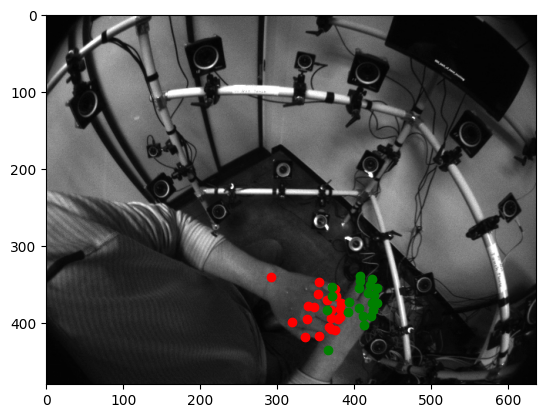

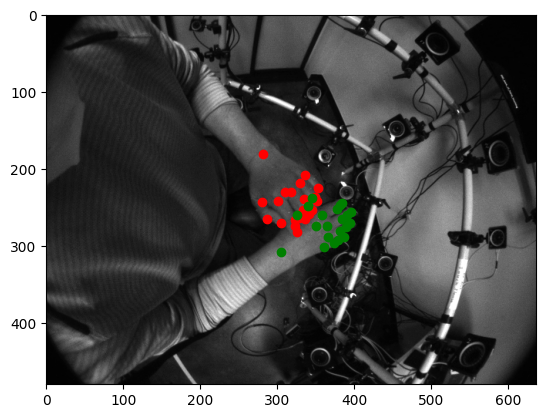

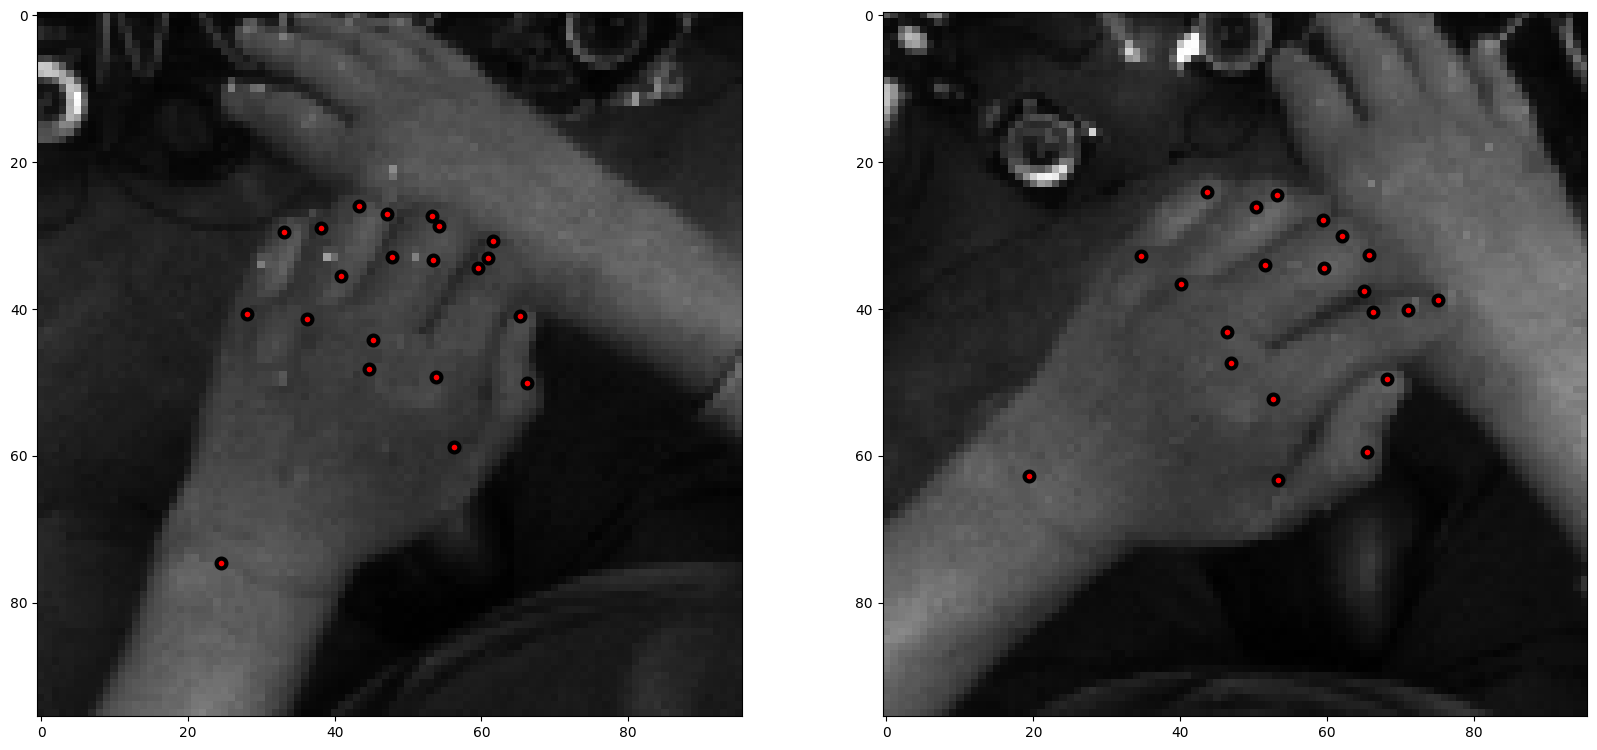

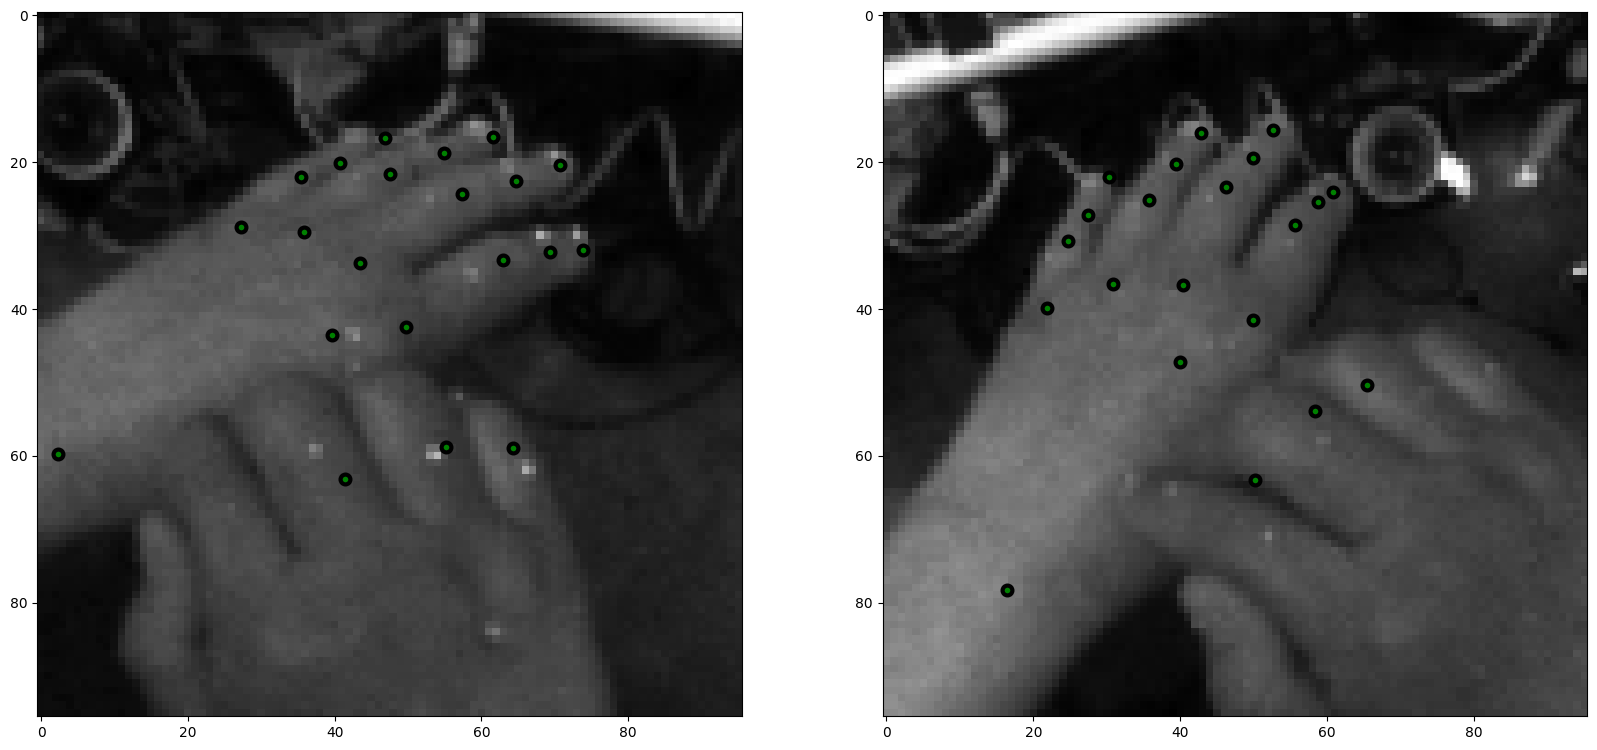

In [ ]:
model_name = "pretrained_weights.torch"
model_path = os.path.join(".", "pretrained_models", model_name)

model = load_pretrained_model(model_path)
model.eval()
tracker = HandTracker(model, HandTrackerOpts())

model_orig = load_pretrained_model(model_path)
model_orig.eval()
tracker_orig = HandTracker(model_orig, HandTrackerOpts())


FRAME_IDX = 29

input_frame, gt_tracking = image_pose_list[FRAME_IDX]


crop_cameras = tracker.gen_crop_cameras(
    [view.camera for view in input_frame.views],
    image_pose_stream._hand_pose_labels.camera_angles,
    hand_model,
    gt_tracking,
    min_num_crops=1,
)

# ==============================================
# visualizes gt_hand_pose and whole image
# for each camera, find if hand is projected to this camera
# if so, visualize the keypoints on the image
for camera_idx in range(len(input_frame.views)) :
    orig_camera = input_frame.views[camera_idx].camera
    keypoints_window_list = []
    # find if crop_camera is generated to this camera
    for hand_idx, crop_camera_dict in crop_cameras.items() :
        if camera_idx in crop_camera_dict.keys() :
            hand_pose = gt_tracking[hand_idx]
            keypoints_world = landmarks_from_hand_pose(
                hand_model,
                hand_pose,
                hand_idx
            )
            keypoints_eye = orig_camera.world_to_eye(keypoints_world)
            keypoints_window = orig_camera.eye_to_window(keypoints_eye)
            keypoints_window_list.append(keypoints_window)
    
    color_list = ['r', 'g', 'b', 'y', 'm', 'c'] 
    if len(keypoints_window_list) > 0 :
        plt.imshow(input_frame.views[camera_idx].image, cmap="gray")
        for i in range(len(keypoints_window_list)) :
            plt.scatter(
                keypoints_window_list[i][:, 0],
                keypoints_window_list[i][:, 1],
                color=color_list[i],
                label='Keypoint'
            )
        plt.show()

res = tracker.track_frame_analysis(
    input_frame, hand_model, crop_cameras, gt_tracking
)
res_orig = tracker_orig.track_frame(
    input_frame, hand_model, crop_cameras
)

In [ ]:
print(res)
print()
print(res_orig)

TrackingResult(hand_poses={0: SingleHandPose(joint_angles=array([-20.309732 ,   5.3512454,  -6.535471 ,  26.554962 ,   1.4724958,
       -21.823591 ,  49.38107  ,  22.892538 ,  -8.410291 ,   0.6643821,
        31.123312 ,  31.99587  , -15.255301 , -16.93614  ,  18.627363 ,
        12.023427 , -14.292766 ,   5.0203934,  38.601395 ,  31.89603  ,
         0.       ,   0.       ], dtype=float32), wrist_xform=array([[-6.0296553e-01,  7.9315954e-01, -8.5620366e-02, -1.0273980e+05],
       [-7.3193592e-01, -5.0732183e-01,  4.5485622e-01,  2.7998534e+05],
       [ 3.1733623e-01,  3.3693057e-01,  8.8643974e-01,  4.8235641e+04],
       [-2.3460128e-10,  8.0545587e-10,  2.7191366e-10,  9.9999994e-01]],
      dtype=float32), hand_confidence=1.0), 1: SingleHandPose(joint_angles=array([ 14.3009615,  43.380657 ,  -0.6696189,   9.187617 , -15.889662 ,
        10.302406 ,  55.148552 ,   3.1119988,   8.408608 ,  37.573902 ,
        64.56309  ,  -2.3201616,  17.976645 ,   7.311602 ,  18.582048 ,
       -

### Try to run mediapipe hand model on datset

In [ ]:
# mediapie does not work well on monochrome image
_ = """
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
hands = mp_hands.Hands(
    max_num_hands = 2,
    
    model_complexity = 1,
    min_detection_confidence = 0.3, 
    min_tracking_confidence = 0.3
)

def visualize_frame(frame_idx):
    input_frame, gt_tracking = image_pose_list[frame_idx]
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    axes = axes.flatten()
    
    for i, frame in enumerate(input_frame.views):
        frame_rgb = cv2.cvtColor(frame.image, cv2.COLOR_GRAY2RGB)
        axes[i].imshow(frame_rgb)
        axes[i].set_title(f"View {i+1}")
        
        mp_result = hands.process(frame_rgb)
        if mp_result.multi_handedness:
            axes[i].set_xlabel(f"{len(mp_result.multi_handedness)} Hand detected")
            for hand_landmarks in mp_result.multi_hand_landmarks:
                hand_landmarks_norm_np = np.array(list(map(
                    lambda l : [l.x, l.y, l.z],
                    hand_landmarks.landmark
                )))
                hand_landmarks_np = hand_landmarks_norm_np * np.array([frame.camera.width, frame.camera.height, 1])
                
                axes[i].scatter(
                    hand_landmarks_np[:, 0],
                    hand_landmarks_np[:, 1],
                    color='blue',
                    label='Keypoint'
                )
        else:
            axes[i].set_xlabel("No hand detected")
    
    plt.tight_layout()
    plt.show()

slider = IntSlider(
    min=0,
    max=len(image_pose_list) - 1,
    step=1,
    value=0,
    description='Frame Index:'
)

output = Output()

interactive_plot = interactive(visualize_frame, frame_idx=slider)
display(interactive_plot, output)
"""

# Play with Tracker

In [ ]:
model_name = "pretrained_weights.torch"
model_path = os.path.join(".", "pretrained_models", model_name)
model = load_pretrained_model(model_path)
model.eval()
tracker = HandTracker(model, HandTrackerOpts())


In [23]:
tracker = HandTracker(model, HandTrackerOpts())
crop_cameras = tracker.gen_crop_cameras(
    [view.camera for view in input_frame.views],
    image_pose_stream._hand_pose_labels.camera_angles,
    hand_model,
    gt_tracking,
    min_num_crops=1,
)
crop_cameras


{0: {1: PinholePlaneCameraModel(96x96, f=(121.23889164733941, 121.23889164733941) c=(47.5, 47.5),
  2: PinholePlaneCameraModel(96x96, f=(132.53766827694966, 132.53766827694966) c=(47.5, 47.5)},
 1: {1: PinholePlaneCameraModel(96x96, f=(159.69272636856715, 159.69272636856715) c=(47.5, 47.5),
  2: PinholePlaneCameraModel(96x96, f=(175.7944199335017, 175.7944199335017) c=(47.5, 47.5)}}

In [24]:
tracker = HandTracker(model, HandTrackerOpts())

crop_cameras = tracker.gen_crop_cameras_analysis(
    #[view.camera for view in input_frame.views],
    input_frame     = input_frame,
    camera_angles   = image_pose_stream._hand_pose_labels.camera_angles,
    hand_model      = hand_model,
    gt_tracking     = gt_tracking,
    min_num_crops   = 1,
)

print(crop_cameras)
print()

crop_cameras = tracker.gen_crop_cameras(
    [view.camera for view in input_frame.views],
    image_pose_stream._hand_pose_labels.camera_angles,
    hand_model,
    gt_tracking,
    min_num_crops=1,
)
print(crop_cameras)

{0: {1: PinholePlaneCameraModel(96x96, f=(121.23889164733941, 121.23889164733941) c=(47.5, 47.5), 2: PinholePlaneCameraModel(96x96, f=(132.53766827694966, 132.53766827694966) c=(47.5, 47.5)}, 1: {1: PinholePlaneCameraModel(96x96, f=(159.69272636856715, 159.69272636856715) c=(47.5, 47.5), 2: PinholePlaneCameraModel(96x96, f=(175.7944199335017, 175.7944199335017) c=(47.5, 47.5)}}

{0: {1: PinholePlaneCameraModel(96x96, f=(121.23889164733941, 121.23889164733941) c=(47.5, 47.5), 2: PinholePlaneCameraModel(96x96, f=(132.53766827694966, 132.53766827694966) c=(47.5, 47.5)}, 1: {1: PinholePlaneCameraModel(96x96, f=(159.69272636856715, 159.69272636856715) c=(47.5, 47.5), 2: PinholePlaneCameraModel(96x96, f=(175.7944199335017, 175.7944199335017) c=(47.5, 47.5)}}


In [ ]:
res = tracker.track_frame(input_frame, hand_model, crop_cameras)

## Put ELP Stereo Camera

In [ ]:

IMG_WIDTH = 640
IMG_HEIGHT = 480

left_to_right_r = np.array([
    9.9997658245714527e-01, 5.5910744958795095e-04, 6.8206990981942916e-03,
    -5.4903304536865717e-04, 9.9999875583076248e-01, -1.4788169738349651e-03,
    -6.8215174296769373e-03, 1.4750375543776898e-03, 9.9997564528550886e-01
]).reshape(3, 3)

left_to_right_t = np.array([
    -5.9457914254177978e-02, -6.8318101539255457e-05, -1.8101725187729225e-04
])

# k1, k2, k3, k4, p1, p2, k5, k6
distortion_coeffs_left = (
    -3.7539305827469560e-02, 
    -8.7553205432575471e-03,
    2.2015408171895236e-03, 
    -6.6218076061138698e-04,
    0, 0, 0, 0
)
camera_to_world_xf_left = np.eye(4)
rotation_left = np.array([
    [9.9997658245714527e-01,  5.5910744958795095e-04,  6.8206990981942916e-03,],
    [-5.4903304536865717e-04, 9.9999875583076248e-01, -1.4788169738349651e-03,],
    [-6.8215174296769373e-03, 1.4750375543776898e-03,  9.9997564528550886e-01 ],
]).reshape(3, 3)
camera_to_world_xf_left[:3, :3] = rotation_left
#camera_to_world_xf_left[:3, 3] = [
cam_left = Fisheye62CameraModel(
    width   = IMG_WIDTH,
    height  = IMG_HEIGHT,
    f       = (2.3877057700850656e+02, 2.3903223316525276e+02),
    c       = (3.1846939219741773e+02, 2.4685137381795201e+02),
    distort_coeffs = distortion_coeffs_left,
    camera_to_world_xf = np.eye(4)
)


distortion_coeffs_right = (
    -3.6790400486095221e-02, 
    -8.2041573433038941e-03,
    1.0552974220937024e-03, 
    -2.5841665172692902e-04,
    0, 0, 0, 0
)
camera_to_world_xf_right = np.eye(4)
rotation_right = np.array([
    [9.9999470555416226e-01, 1.1490100298631428e-03, 3.0444440536135159e-03,],
    [-1.1535052313709361e-03, 9.9999824663038117e-01, 1.4751819698614872e-03,],
    [-3.0427437166985561e-03, -1.4786859417328980e-03, 9.9999427758290704e-01 ],
]).reshape(3, 3)
camera_to_world_xf_right[:3, :3] = rotation_right
camera_to_world_xf_right[:3, 3] = left_to_right_t
#camera_to_world_xf_right[:3, 3] = [
cam_right = Fisheye62CameraModel(
    width   = IMG_WIDTH,
    height  = IMG_HEIGHT,
    f       = (2.3952183485043457e+02, 2.3981379751051574e+02),
    c       = (3.1286224145189811e+02, 2.5158397962108106e+02),
    distort_coeffs = distortion_coeffs_right,
    camera_to_world_xf = camera_to_world_xf_right
)

def open_stereo_camera(IMAGE_WIDTH, IMAGE_HEIGHT, CAM_ID_MAX = 10) :
    for CAM_ID in range(-1, CAM_ID_MAX) :
        cap = cv2.VideoCapture(CAM_ID)
        cap.set(cv2.CAP_PROP_FRAME_WIDTH, IMAGE_WIDTH * 2)
        cap.set(cv2.CAP_PROP_FRAME_HEIGHT, IMAGE_HEIGHT)
        if cap.isOpened() :
            print(f"Camera ID {CAM_ID} Frame Width {cap.get(cv2.CAP_PROP_FRAME_WIDTH)}")
            return cap

CAM_ID_MAX = 10


In [ ]:
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
hands_left_cam = mp_hands.Hands(
    max_num_hands = 2,
    model_complexity = 1,
    min_detection_confidence = 0.3, 
    min_tracking_confidence = 0.3
)

hands_right_cam = mp_hands.Hands(
    max_num_hands = 2,   
    model_complexity = 1,
    min_detection_confidence = 0.3, 
    min_tracking_confidence = 0.3
)

In [ ]:
cap = open_stereo_camera(IMG_WIDTH, IMG_HEIGHT, CAM_ID_MAX)
ret, frame_stereo = cap.read()
frame_stereo = cv2.cvtColor(frame_stereo, cv2.COLOR_BGR2RGB)
frame_left = frame_stereo[:, :IMG_WIDTH]
frame_right = frame_stereo[:, IMG_WIDTH:]
frame_right_gray = cv2.cvtColor(frame_right, cv2.COLOR_RGB2GRAY)
frame_left_gray = cv2.cvtColor(frame_left, cv2.COLOR_RGB2GRAY)
cap.release()

hand_pose_result_left_cam = hands_left_cam.process(frame_left)
# key : handedness index
# value : window coordinate hand pose
if hand_pose_result_left_cam.multi_handedness :
    hand_pose_window_left_cam : Dict[int, np.ndarray] = dict(zip(
        list(map(
            lambda x : x.classification[0].index,
            hand_pose_result_left_cam.multi_handedness
        )),
        list(map(
            lambda landamrk_per_hand : np.array(list(map(
                lambda l : [l.x, l.y, l.z],
                landamrk_per_hand.landmark
            ))) * np.array([frame_left.shape[1], frame_left.shape[0], 1]),
            hand_pose_result_left_cam.multi_hand_landmarks
        ))
    ))
print("left cam detected hand index : ", *hand_pose_window_left_cam.keys())

hand_pose_result_right_cam = hands_right_cam.process(frame_right)
if hand_pose_result_right_cam.multi_handedness :
    hand_pose_window_right_cam : Dict[int, np.ndarray] = dict(zip(
        list(map(
            lambda x : x.classification[0].index,
            hand_pose_result_right_cam.multi_handedness
        )),
        list(map(
            lambda landamrk_per_hand : np.array(list(map(
                lambda l : [l.x, l.y, l.z],
                landamrk_per_hand.landmark
            ))) * np.array([frame_right.shape[1], frame_right.shape[0], 1]),
            hand_pose_result_right_cam.multi_hand_landmarks
        ))
    ))
    hand_pose_window_right_cam
print("right cam detected hand index : ", *hand_pose_window_right_cam.keys())

VIS_HAND_IDX_LIST = [0, 1]\
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(frame_left)
for hand_idx in VIS_HAND_IDX_LIST :
    if hand_idx in hand_pose_window_left_cam :
        print(hand_idx)
        plt.scatter(
            hand_pose_window_left_cam[hand_idx][:, 0],
            hand_pose_window_left_cam[hand_idx][:, 1],
            color='blue',
            label='Keypoint'
        )

plt.subplot(1, 2, 2)
plt.imshow(frame_right)
for hand_idx in VIS_HAND_IDX_LIST :
    if hand_idx in hand_pose_window_right_cam :
        plt.scatter(
            hand_pose_window_right_cam[hand_idx][:, 0],
            hand_pose_window_right_cam[hand_idx][:, 1],
            color='blue',
            label='Keypoint'
    )   
plt.show()

In [ ]:
model_name = "pretrained_weights.torch"
model_path = os.path.join(".", "pretrained_models", model_name)
model = load_pretrained_model(model_path)
model.eval()
tracker = HandTracker(model, HandTrackerOpts())

crop_camera_dict = tracker.gen_crop_cameras_from_stereo_camera_with_window_hand_pose(
    camera_left = cam_left,
    camera_right = cam_right,
    window_hand_pose_left = hand_pose_window_left_cam,
    window_hand_pose_right = hand_pose_window_right_cam
)
crop_camera_dict

fisheye_stereo_input_frame = InputFrame(
    views = [
        ViewData(
            image = frame_left_gray,
            camera = cam_left,
            camera_angle = 0,
        ),
        ViewData(
            image = frame_right_gray,
            camera = cam_right,
            camera_angle = 0,
        )
    ]
)
tracker.visualize_crop_cameras(
    input_frame = fisheye_stereo_input_frame,
    window_hand_pose_left = hand_pose_window_left_cam,
    window_hand_pose_right = hand_pose_window_right_cam,
    crop_camera_dict = crop_camera_dict
)

In [ ]:
print(fisheye_stereo_input_frame.views[0].camera)
print(fisheye_stereo_input_frame.views[0].camera.camera_to_world_xf)

print()

print(fisheye_stereo_input_frame.views[1].camera)
print(fisheye_stereo_input_frame.views[1].camera.camera_to_world_xf)



In [ ]:
res = tracker.track_frame_analysis(fisheye_stereo_input_frame, hand_model, crop_camera_dict)

In [ ]:
tracked_keypoints_dict = {}
for hand_idx in res.hand_poses.keys() :
    tracked_keypoints = landmarks_from_hand_pose(
        hand_model, res.hand_poses[hand_idx], hand_idx
    )
    tracked_keypoints_dict[hand_idx] = tracked_keypoints

camera_left_pose = cam_left.camera_to_world_xf[:3, 3] * M_TO_MM
camera_left_x_axis = cam_left.camera_to_world_xf[:3, 0] * M_TO_MM
camera_left_y_axis = cam_left.camera_to_world_xf[:3, 1] * M_TO_MM 
camera_left_z_axis = cam_left.camera_to_world_xf[:3, 2] * M_TO_MM

camera_right_pose = cam_right.camera_to_world_xf[:3, 3] * M_TO_MM
camera_right_x_axis = cam_right.camera_to_world_xf[:3, 0] * M_TO_MM
camera_right_y_axis = cam_right.camera_to_world_xf[:3, 1] * M_TO_MM
camera_right_z_axis = cam_right.camera_to_world_xf[:3, 2] * M_TO_MM

print(camera_left_pose)
print(camera_right_pose)
# visualize tracked_keypoints_dict, camera_left, camera_right using plotly

import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter3d(
    x = tracked_keypoints_dict[0][:, 0],
    y = tracked_keypoints_dict[0][:, 1],
    z = tracked_keypoints_dict[0][:, 2],
    mode = 'markers',
    marker = dict(
        size = 5,
        color = 'blue',
        opacity = 0.5
    )
))
fig.add_trace(go.Scatter3d(
    x = tracked_keypoints_dict[1][:, 0],
    y = tracked_keypoints_dict[1][:, 1],
    z = tracked_keypoints_dict[1][:, 2],
    mode = 'markers',
    marker = dict(
        size = 5,
        color = 'red',
        opacity = 0.5
    )
))

# add camera axis 
fig.add_trace(go.Scatter3d(
    x = [0, camera_left_x_axis[0]],
    y = [0, camera_left_x_axis[1]],
    z = [0, camera_left_x_axis[2]],
    mode = 'lines',
    line = dict(
        color = 'red',
        width = 5
    )
))
fig.add_trace(go.Scatter3d(
    x = [0, camera_left_y_axis[0]],
    y = [0, camera_left_y_axis[1]],
    z = [0, camera_left_y_axis[2]],
    mode = 'lines',
    line = dict(
        color = 'green',
        width = 5
    )
))
fig.add_trace(go.Scatter3d(
    x = [0, camera_left_z_axis[0]],
    y = [0, camera_left_z_axis[1]],
    z = [0, camera_left_z_axis[2]],
    mode = 'lines',
    line = dict(
        color = 'blue',
        width = 5
    )
))
fig.add_trace(go.Scatter3d(
    x = [0, camera_right_x_axis[0]],
    y = [0, camera_right_x_axis[1]],
    z = [0, camera_right_x_axis[2]],
    mode = 'lines',
    line = dict(
        color = 'red',
        width = 5
    )
))
fig.add_trace(go.Scatter3d(
    x = [0, camera_right_y_axis[0]],
    y = [0, camera_right_y_axis[1]],
    z = [0, camera_right_y_axis[2]],
    mode = 'lines',
    line = dict(
        color = 'green',
        width = 5
    )
))
fig.add_trace(go.Scatter3d(
    x = [0, camera_right_z_axis[0]],
    y = [0, camera_right_z_axis[1]],
    z = [0, camera_right_z_axis[2]],
    mode = 'lines',
    line = dict(
        color = 'blue',
        width = 5
    )
))

fig.show()

In [ ]:
# Joint Altogether

import socket

cap = open_stereo_camera(IMG_WIDTH, IMG_HEIGHT, CAM_ID_MAX)

model_name = "pretrained_weights.torch"
model_path = os.path.join(".", "pretrained_models", model_name)
model = load_pretrained_model(model_path)
model.eval()
tracker = HandTracker(model, HandTrackerOpts())

sock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
serverAddressPort = ("127.0.0.1", 5052)

idx = 0

while True :
    idx += 1
    
    ret, frame_stereo = cap.read()
    frame_stereo = cv2.cvtColor(frame_stereo, cv2.COLOR_BGR2RGB)
    frame_left = frame_stereo[:, :IMG_WIDTH]
    frame_right = frame_stereo[:, IMG_WIDTH:]
    frame_right_gray = cv2.cvtColor(frame_right, cv2.COLOR_RGB2GRAY)
    frame_left_gray = cv2.cvtColor(frame_left, cv2.COLOR_RGB2GRAY)

    hand_pose_result_left_cam = hands_left_cam.process(frame_left)
    if hand_pose_result_left_cam.multi_handedness :
        hand_pose_window_left_cam : Dict[int, np.ndarray] = dict(zip(
            list(map(
                lambda x : x.classification[0].index,
                hand_pose_result_left_cam.multi_handedness
            )),
            list(map(
                lambda landamrk_per_hand : np.array(list(map(
                    lambda l : [l.x, l.y, l.z],
                    landamrk_per_hand.landmark
                ))) * np.array([frame_left.shape[1], frame_left.shape[0], 1]),
                hand_pose_result_left_cam.multi_hand_landmarks
            ))
        ))

    hand_pose_result_right_cam = hands_right_cam.process(frame_right)
    if hand_pose_result_right_cam.multi_handedness :
        hand_pose_window_right_cam : Dict[int, np.ndarray] = dict(zip(
            list(map(
                lambda x : x.classification[0].index,
                hand_pose_result_right_cam.multi_handedness
            )),
            list(map(
                lambda landamrk_per_hand : np.array(list(map(
                    lambda l : [l.x, l.y, l.z],
                    landamrk_per_hand.landmark
                ))) * np.array([frame_right.shape[1], frame_right.shape[0], 1]),
                hand_pose_result_right_cam.multi_hand_landmarks
            ))
        ))
        hand_pose_window_right_cam

    fisheye_stereo_input_frame = InputFrame(
        views = [
            ViewData(
                image = frame_left_gray,
                camera = cam_left,
                camera_angle = 0,
            ),
            ViewData(
                image = frame_right_gray,
                camera = cam_right,
                camera_angle = 0,
            )
        ]
    )

    crop_camera_dict = tracker.gen_crop_cameras_from_stereo_camera_with_window_hand_pose(
        camera_left = cam_left,
        camera_right = cam_right,
        window_hand_pose_left = hand_pose_window_left_cam,
        window_hand_pose_right = hand_pose_window_right_cam
    )

    res = tracker.track_frame(fisheye_stereo_input_frame, hand_model, crop_camera_dict)

    tracked_keypoints_dict = {}
    for hand_idx in res.hand_poses.keys() :
        tracked_keypoints = landmarks_from_hand_pose(
            hand_model, res.hand_poses[hand_idx], hand_idx
        )
        tracked_keypoints_dict[hand_idx] = tracked_keypoints

    # sock.sendto(str.encode(str(data)), serverAddressPort)
    
    # for hand_idx, keypoints in tracked_keypoints_dict.items() :
    #     print(hand_idx, keypoints.shape)
    #     print(keypoints.tolist())
    if 0 in tracked_keypoints_dict :
        refined_keypoints = tracked_keypoints_dict[0] / 10 + 100
        refined_keypoints[:, 1] = 200 - refined_keypoints[:, 1]
        
        content = str(refined_keypoints.reshape(-1).tolist())
        print(content)
        sock.sendto(str.encode(content), serverAddressPort)
    
cap.release()

In [ ]:
arr = np.arange(12).reshape(3, 4)
print(arr)
print(arr.reshape(-1))

In [ ]:
ll = list(range(10))
ll.extend([11, 12, 13])
print(ll)

In [ ]:
refined_keypoints.shape